In [1]:
# AeroCNN-II
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
n_kernel=100
l2Regularizer=1e-09
kernel_size1 = 3
kernel_size2 = 3
#kernel_size3 = 5
n_grid = 128
strides1 = 1
strides2 = 2
lr = 5e-04
val_rate=0.2
test_rate=0.1
input_size = 100
batch_size = 20

In [3]:
main_directory = 'D:\\20221101AeroCNNII'
os.chdir(main_directory)

In [4]:
case_directory = 'validation'+str(val_rate)+'test'+str(test_rate)
if not os.path.exists(case_directory):
    os.makedirs(case_directory)
    
case_storage = main_directory+"\\alpha16"

In [5]:
aa = np.ones((133,1))*16

In [6]:
os.chdir('D:\\AeroCNN2Inputs')

In [7]:
origin = "D:\\AeroCNN2Inputs"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [8]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [9]:
image_df = pd.DataFrame()
for i in range(1, 134):
    csv_file_name = origin + '\\airfoil' + str(i) + "_alpha16.csv"
    data = pd.read_csv(csv_file_name, header=None)
    image_df = pd.concat([image_df, data], axis=0)

In [10]:
image_np = image_df.iloc[:, :].values

In [11]:
image = image_np.reshape((133, 100, 100, 1))

In [12]:
image = 1-image/100

In [13]:
path = 'D:\\airfoilFlowField'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.csv')]

In [14]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 0].values
geometry_orig2 = airfoilName_df.iloc[:, 1].values

In [15]:
data_name = path + '\\' + str(geometry_orig[0]) + "alpha16_interpolated.csv"
print(data_name)

D:\airfoilFlowField\airfoil1alpha16_interpolated.csv


In [16]:
path = 'D:\\rotatedInterpolation_pow2\\n_grid128\\velocityMagnitudeField'

In [17]:
Vmag_df = pd.DataFrame()
for i in range(1, 134):
    data_name = path + '\\' + str(geometry_orig[i-1]) + "alpha16_velocityMagnitudeInterpolated.csv"
    data = pd.read_csv(data_name, header=None)
    Vmag_df = pd.concat([Vmag_df, data], axis=0)

In [18]:
y_imp = Vmag_df.iloc[:, :].values

In [19]:
y_imp.shape

(17157, 129)

In [20]:
y = y_imp.reshape((133, n_grid+1, n_grid+1,1))

In [21]:
targetMax = np.max(y)
targetMin = np.min(y)

In [22]:
y_nor = (y - targetMin)/(targetMax-targetMin)

In [23]:
geometry = np.zeros((133,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig2:
    index_ = np.where(geometry_orig2==i)
    geometry[index_,:] = np.asarray(i)

In [24]:
geometry.shape

(133, 1)

In [25]:
x_all, x_test, aa_all, aa_test, geo_all, geo_test, y_all, y_test = train_test_split(
    image, aa, geometry, y, test_size=test_rate, random_state=1)

In [26]:
x_train, x_val, aa_train, aa_val, geo_train, geo_val, y_train, y_val = train_test_split(
    x_all, aa_all, geo_all, y_all, test_size=val_rate/(1-test_rate), random_state=1)

In [27]:
y_train_nor = (y_train-targetMin)/(targetMax-targetMin)

In [28]:
y_val_nor = (y_val-targetMin)/(targetMax-targetMin)

In [29]:
y_test_nor = (y_test-targetMin)/(targetMax-targetMin)

In [30]:
tf.keras.backend.set_image_data_format('channels_last')

In [31]:
input_image = tf.keras.Input(shape=(100, 100, 1))

x_conv1 = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides1, strides1),
                                 activation='relu', padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                 name='Conv2DLayer1')(input_image)
x_maxpool1 = tf.keras.layers.MaxPooling2D((2,2))(x_conv1)
x_conv2 = tf.keras.layers.Conv2D(n_kernel*2, (kernel_size1, kernel_size1), strides=(strides1, strides1),
                                 activation='relu', padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                 name='Conv2DLayer2')(x_maxpool1)
x_maxpool2 = tf.keras.layers.MaxPooling2D((2,2))(x_conv2)

x_deconv1 = tf.keras.layers.Conv2DTranspose(n_kernel*2, (kernel_size1, kernel_size1),
                                            strides = (strides2, strides2),
                                            kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                            padding='same', activation='relu')(x_maxpool2)
x_deconv2 = tf.keras.layers.Conv2DTranspose(n_kernel, (kernel_size1, kernel_size1),
                                            strides = (strides2, strides2),
                                            kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                            padding='same', activation='relu')(x_deconv1)

output_impr = tf.keras.layers.Conv2D(1, (kernel_size1, kernel_size1), strides=(strides1, strides1),
                                     activation='relu', padding='same',
                                     kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                     name='Conv2Doutput')(x_deconv2)
x_flat = tf.keras.layers.Flatten()(output_impr)
x_fc = tf.keras.layers.Dense(units=(n_grid+1)**2, activation='linear', name='outputLayer',
                             kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_flat)
output_data = tf.keras.layers.Reshape((n_grid+1, n_grid+1,1))(x_fc)
# CNN autoencoder
model = tf.keras.Model(input_image, output_data)

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 Conv2DLayer1 (Conv2D)       (None, 100, 100, 100)     1000      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 100)      0         
 )                                                               
                                                                 
 Conv2DLayer2 (Conv2D)       (None, 50, 50, 200)       180200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 200)      0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 50, 50, 200)      360200

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [34]:
os.chdir(case_storage)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=70, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-06,
                                          verbose=1)

In [35]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train_nor, validation_data=[x_val, y_val_nor], batch_size=batch_size,
                    epochs=5000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/5000
5/5 [==============================] - 8s 497ms/step - loss: 0.1230 - rmse: 0.3506 - val_loss: 0.1794 - val_rmse: 0.4236 - lr: 5.0000e-04
Epoch 2/5000
5/5 [==============================] - 1s 243ms/step - loss: 0.0643 - rmse: 0.2536 - val_loss: 0.0709 - val_rmse: 0.2663 - lr: 5.0000e-04
Epoch 3/5000
5/5 [==============================] - 1s 121ms/step - loss: 0.0476 - rmse: 0.2182 - val_loss: 0.0072 - val_rmse: 0.0850 - lr: 5.0000e-04
Epoch 4/5000
5/5 [==============================] - 1s 129ms/step - loss: 0.0145 - rmse: 0.1202 - val_loss: 0.0019 - val_rmse: 0.0439 - lr: 5.0000e-04
Epoch 5/5000
5/5 [==============================] - 1s 119ms/step - loss: 0.0091 - rmse: 0.0953 - val_loss: 0.0081 - val_rmse: 0.0899 - lr: 5.0000e-04
Epoch 6/5000
5/5 [==============================] - 1s 124ms/step - loss: 0.0056 - rmse: 0.0745 - val_loss: 0.0053 - val_rmse: 0.0726 - lr: 5.0000e-04
Epoch 7/5000
5/5 [==============================] - 1s 133ms/step - loss: 0.0026 - rmse: 0.050

Epoch 53/5000
5/5 [==============================] - 1s 120ms/step - loss: 7.8970e-04 - rmse: 0.0279 - val_loss: 7.4269e-04 - val_rmse: 0.0270 - lr: 5.0000e-04
Epoch 54/5000
5/5 [==============================] - 0s 47ms/step - loss: 7.9752e-04 - rmse: 0.0280 - val_loss: 7.4621e-04 - val_rmse: 0.0271 - lr: 5.0000e-04
Epoch 55/5000
5/5 [==============================] - 0s 46ms/step - loss: 7.8947e-04 - rmse: 0.0279 - val_loss: 7.3447e-04 - val_rmse: 0.0269 - lr: 5.0000e-04
Epoch 56/5000
5/5 [==============================] - 0s 46ms/step - loss: 8.0230e-04 - rmse: 0.0281 - val_loss: 7.3750e-04 - val_rmse: 0.0269 - lr: 5.0000e-04
Epoch 57/5000
5/5 [==============================] - 0s 47ms/step - loss: 8.1379e-04 - rmse: 0.0283 - val_loss: 7.4383e-04 - val_rmse: 0.0270 - lr: 5.0000e-04
Epoch 58/5000
5/5 [==============================] - 0s 47ms/step - loss: 7.9693e-04 - rmse: 0.0280 - val_loss: 7.2948e-04 - val_rmse: 0.0268 - lr: 5.0000e-04
Epoch 59/5000
5/5 [==========================

5/5 [==============================] - 0s 48ms/step - loss: 4.7900e-04 - rmse: 0.0216 - val_loss: 4.2828e-04 - val_rmse: 0.0204 - lr: 5.0000e-04
Epoch 105/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.9072e-04 - rmse: 0.0219 - val_loss: 4.4896e-04 - val_rmse: 0.0209 - lr: 5.0000e-04
Epoch 106/5000
5/5 [==============================] - 0s 48ms/step - loss: 4.7605e-04 - rmse: 0.0215 - val_loss: 4.2395e-04 - val_rmse: 0.0203 - lr: 5.0000e-04
Epoch 107/5000
5/5 [==============================] - 0s 48ms/step - loss: 4.8221e-04 - rmse: 0.0217 - val_loss: 4.7442e-04 - val_rmse: 0.0215 - lr: 5.0000e-04
Epoch 108/5000
5/5 [==============================] - 1s 122ms/step - loss: 4.5964e-04 - rmse: 0.0211 - val_loss: 4.1171e-04 - val_rmse: 0.0200 - lr: 5.0000e-04
Epoch 109/5000
5/5 [==============================] - 0s 48ms/step - loss: 4.6632e-04 - rmse: 0.0213 - val_loss: 4.2992e-04 - val_rmse: 0.0204 - lr: 5.0000e-04
Epoch 110/5000
5/5 [==============================] - 

5/5 [==============================] - 1s 122ms/step - loss: 3.7876e-04 - rmse: 0.0191 - val_loss: 3.7673e-04 - val_rmse: 0.0191 - lr: 5.0000e-04
Epoch 156/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.8510e-04 - rmse: 0.0193 - val_loss: 3.4513e-04 - val_rmse: 0.0182 - lr: 5.0000e-04
Epoch 157/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.8664e-04 - rmse: 0.0193 - val_loss: 3.9196e-04 - val_rmse: 0.0195 - lr: 5.0000e-04
Epoch 158/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.9961e-04 - rmse: 0.0197 - val_loss: 3.6956e-04 - val_rmse: 0.0189 - lr: 5.0000e-04
Epoch 159/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.8801e-04 - rmse: 0.0194 - val_loss: 3.5186e-04 - val_rmse: 0.0184 - lr: 5.0000e-04
Epoch 160/5000
5/5 [==============================] - 0s 49ms/step - loss: 3.8745e-04 - rmse: 0.0193 - val_loss: 4.0675e-04 - val_rmse: 0.0198 - lr: 5.0000e-04
Epoch 161/5000
5/5 [==============================] - 

5/5 [==============================] - 1s 122ms/step - loss: 3.2739e-04 - rmse: 0.0177 - val_loss: 3.1927e-04 - val_rmse: 0.0175 - lr: 5.0000e-04
Epoch 207/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.3003e-04 - rmse: 0.0178 - val_loss: 3.4006e-04 - val_rmse: 0.0181 - lr: 5.0000e-04
Epoch 208/5000
5/5 [==============================] - 1s 121ms/step - loss: 3.2250e-04 - rmse: 0.0176 - val_loss: 3.2342e-04 - val_rmse: 0.0176 - lr: 5.0000e-04
Epoch 209/5000
5/5 [==============================] - 0s 48ms/step - loss: 3.2533e-04 - rmse: 0.0177 - val_loss: 3.5708e-04 - val_rmse: 0.0185 - lr: 5.0000e-04
Epoch 210/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.2398e-04 - rmse: 0.0176 - val_loss: 3.1740e-04 - val_rmse: 0.0174 - lr: 5.0000e-04
Epoch 211/5000
5/5 [==============================] - 0s 48ms/step - loss: 3.3099e-04 - rmse: 0.0178 - val_loss: 3.2784e-04 - val_rmse: 0.0177 - lr: 5.0000e-04
Epoch 212/5000
5/5 [==============================] -

5/5 [==============================] - 0s 47ms/step - loss: 2.9594e-04 - rmse: 0.0168 - val_loss: 3.2154e-04 - val_rmse: 0.0176 - lr: 5.0000e-04
Epoch 258/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.9364e-04 - rmse: 0.0167 - val_loss: 3.1961e-04 - val_rmse: 0.0175 - lr: 5.0000e-04
Epoch 259/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.0206e-04 - rmse: 0.0170 - val_loss: 3.2500e-04 - val_rmse: 0.0177 - lr: 5.0000e-04
Epoch 260/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.8878e-04 - rmse: 0.0166 - val_loss: 3.3062e-04 - val_rmse: 0.0178 - lr: 5.0000e-04
Epoch 261/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.8640e-04 - rmse: 0.0165 - val_loss: 3.2104e-04 - val_rmse: 0.0175 - lr: 5.0000e-04
Epoch 262/5000
5/5 [==============================] - 1s 120ms/step - loss: 2.8131e-04 - rmse: 0.0164 - val_loss: 3.1177e-04 - val_rmse: 0.0173 - lr: 5.0000e-04
Epoch 263/5000
5/5 [==============================] - 

5/5 [==============================] - 0s 48ms/step - loss: 2.7922e-04 - rmse: 0.0163 - val_loss: 3.7074e-04 - val_rmse: 0.0189 - lr: 5.0000e-04
Epoch 309/5000
5/5 [==============================] - 0s 48ms/step - loss: 2.7472e-04 - rmse: 0.0162 - val_loss: 3.0305e-04 - val_rmse: 0.0170 - lr: 5.0000e-04
Epoch 310/5000
5/5 [==============================] - 1s 123ms/step - loss: 2.5902e-04 - rmse: 0.0157 - val_loss: 3.4937e-04 - val_rmse: 0.0183 - lr: 5.0000e-04
Epoch 311/5000
5/5 [==============================] - 0s 48ms/step - loss: 2.5886e-04 - rmse: 0.0157 - val_loss: 3.0938e-04 - val_rmse: 0.0172 - lr: 5.0000e-04
Epoch 312/5000
5/5 [==============================] - 0s 48ms/step - loss: 2.7288e-04 - rmse: 0.0161 - val_loss: 3.4926e-04 - val_rmse: 0.0183 - lr: 5.0000e-04
Epoch 313/5000
5/5 [==============================] - 1s 127ms/step - loss: 2.5560e-04 - rmse: 0.0156 - val_loss: 3.1376e-04 - val_rmse: 0.0173 - lr: 5.0000e-04
Epoch 314/5000
5/5 [==============================] -

5/5 [==============================] - 0s 47ms/step - loss: 2.4089e-04 - rmse: 0.0151 - val_loss: 3.1219e-04 - val_rmse: 0.0173 - lr: 5.0000e-04
Epoch 360/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.4382e-04 - rmse: 0.0152 - val_loss: 3.3964e-04 - val_rmse: 0.0181 - lr: 5.0000e-04
Epoch 361/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.6158e-04 - rmse: 0.0158 - val_loss: 3.3026e-04 - val_rmse: 0.0178 - lr: 5.0000e-04
Epoch 362/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.4272e-04 - rmse: 0.0152 - val_loss: 3.1686e-04 - val_rmse: 0.0174 - lr: 5.0000e-04
Epoch 363/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.3855e-04 - rmse: 0.0150 - val_loss: 3.5614e-04 - val_rmse: 0.0185 - lr: 5.0000e-04
Epoch 364/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.4655e-04 - rmse: 0.0153 - val_loss: 3.2986e-04 - val_rmse: 0.0178 - lr: 5.0000e-04
Epoch 365/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 48ms/step - loss: 2.0527e-04 - rmse: 0.0139 - val_loss: 3.5819e-04 - val_rmse: 0.0186 - lr: 5.0000e-04
Epoch 411/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.2522e-04 - rmse: 0.0146 - val_loss: 3.6153e-04 - val_rmse: 0.0187 - lr: 5.0000e-04
Epoch 412/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1747e-04 - rmse: 0.0143 - val_loss: 3.1780e-04 - val_rmse: 0.0175 - lr: 5.0000e-04
Epoch 413/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1290e-04 - rmse: 0.0141 - val_loss: 4.0047e-04 - val_rmse: 0.0197 - lr: 5.0000e-04
Epoch 414/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.3041e-04 - rmse: 0.0147 - val_loss: 3.4372e-04 - val_rmse: 0.0182 - lr: 5.0000e-04
Epoch 415/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.2005e-04 - rmse: 0.0144 - val_loss: 3.5858e-04 - val_rmse: 0.0186 - lr: 5.0000e-04
Epoch 416/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 47ms/step - loss: 2.3834e-04 - rmse: 0.0150 - val_loss: 3.4611e-04 - val_rmse: 0.0182 - lr: 5.0000e-04
Epoch 462/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.0053e-04 - rmse: 0.0137 - val_loss: 4.0119e-04 - val_rmse: 0.0197 - lr: 5.0000e-04
Epoch 463/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.9949e-04 - rmse: 0.0137 - val_loss: 3.6798e-04 - val_rmse: 0.0188 - lr: 5.0000e-04
Epoch 464/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.7656e-04 - rmse: 0.0162 - val_loss: 5.2386e-04 - val_rmse: 0.0226 - lr: 5.0000e-04
Epoch 465/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.5912e-04 - rmse: 0.0157 - val_loss: 3.7394e-04 - val_rmse: 0.0190 - lr: 5.0000e-04
Epoch 466/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1763e-04 - rmse: 0.0143 - val_loss: 4.2228e-04 - val_rmse: 0.0202 - lr: 5.0000e-04
Epoch 467/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 47ms/step - loss: 1.6671e-04 - rmse: 0.0124 - val_loss: 3.7351e-04 - val_rmse: 0.0190 - lr: 5.0000e-04
Epoch 513/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.6862e-04 - rmse: 0.0125 - val_loss: 3.7877e-04 - val_rmse: 0.0191 - lr: 5.0000e-04
Epoch 514/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.8419e-04 - rmse: 0.0131 - val_loss: 3.9232e-04 - val_rmse: 0.0195 - lr: 5.0000e-04
Epoch 515/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.7699e-04 - rmse: 0.0128 - val_loss: 3.9335e-04 - val_rmse: 0.0195 - lr: 5.0000e-04
Epoch 516/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.8677e-04 - rmse: 0.0132 - val_loss: 4.0962e-04 - val_rmse: 0.0199 - lr: 5.0000e-04
Epoch 517/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.8266e-04 - rmse: 0.0130 - val_loss: 3.9313e-04 - val_rmse: 0.0195 - lr: 5.0000e-04
Epoch 518/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 48ms/step - loss: 1.7200e-04 - rmse: 0.0126 - val_loss: 3.6719e-04 - val_rmse: 0.0188 - lr: 5.0000e-04
Epoch 564/5000
5/5 [==============================] - 0s 48ms/step - loss: 1.6239e-04 - rmse: 0.0122 - val_loss: 4.1012e-04 - val_rmse: 0.0199 - lr: 5.0000e-04
Epoch 565/5000
5/5 [==============================] - 0s 48ms/step - loss: 1.8204e-04 - rmse: 0.0130 - val_loss: 3.6485e-04 - val_rmse: 0.0188 - lr: 5.0000e-04
Epoch 566/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.6019e-04 - rmse: 0.0121 - val_loss: 3.7646e-04 - val_rmse: 0.0191 - lr: 5.0000e-04
Epoch 567/5000
5/5 [==============================] - 0s 48ms/step - loss: 1.5758e-04 - rmse: 0.0120 - val_loss: 4.0943e-04 - val_rmse: 0.0199 - lr: 5.0000e-04
Epoch 568/5000
5/5 [==============================] - 0s 48ms/step - loss: 1.5676e-04 - rmse: 0.0120 - val_loss: 3.7720e-04 - val_rmse: 0.0191 - lr: 5.0000e-04
Epoch 569/5000
5/5 [==============================] - 1

5/5 [==============================] - 0s 47ms/step - loss: 1.5662e-04 - rmse: 0.0120 - val_loss: 4.2684e-04 - val_rmse: 0.0203 - lr: 5.0000e-04
Epoch 615/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.6038e-04 - rmse: 0.0121 - val_loss: 4.0613e-04 - val_rmse: 0.0198 - lr: 5.0000e-04
Epoch 616/5000
5/5 [==============================] - 1s 121ms/step - loss: 1.4041e-04 - rmse: 0.0113 - val_loss: 3.7871e-04 - val_rmse: 0.0191 - lr: 5.0000e-04
Epoch 617/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.4774e-04 - rmse: 0.0116 - val_loss: 4.2611e-04 - val_rmse: 0.0203 - lr: 5.0000e-04
Epoch 618/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.4456e-04 - rmse: 0.0115 - val_loss: 3.9181e-04 - val_rmse: 0.0195 - lr: 5.0000e-04
Epoch 619/5000
5/5 [==============================] - 1s 125ms/step - loss: 1.3847e-04 - rmse: 0.0112 - val_loss: 3.9127e-04 - val_rmse: 0.0194 - lr: 5.0000e-04
Epoch 620/5000
5/5 [==============================] -

5/5 [==============================] - 0s 47ms/step - loss: 1.4815e-04 - rmse: 0.0116 - val_loss: 4.2073e-04 - val_rmse: 0.0202 - lr: 5.0000e-04
Epoch 666/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.6339e-04 - rmse: 0.0123 - val_loss: 3.9389e-04 - val_rmse: 0.0195 - lr: 5.0000e-04
Epoch 667/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.3947e-04 - rmse: 0.0112 - val_loss: 4.3613e-04 - val_rmse: 0.0206 - lr: 5.0000e-04
Epoch 668/5000
5/5 [==============================] - 1s 121ms/step - loss: 1.2744e-04 - rmse: 0.0107 - val_loss: 3.9301e-04 - val_rmse: 0.0195 - lr: 5.0000e-04
Epoch 669/5000
5/5 [==============================] - 1s 127ms/step - loss: 1.2460e-04 - rmse: 0.0106 - val_loss: 4.0257e-04 - val_rmse: 0.0197 - lr: 5.0000e-04
Epoch 670/5000
5/5 [==============================] - 1s 191ms/step - loss: 1.2372e-04 - rmse: 0.0105 - val_loss: 4.3217e-04 - val_rmse: 0.0205 - lr: 5.0000e-04
Epoch 671/5000
5/5 [==============================] 

5/5 [==============================] - 0s 47ms/step - loss: 1.2391e-04 - rmse: 0.0105 - val_loss: 4.0096e-04 - val_rmse: 0.0197 - lr: 5.0000e-04
Epoch 717/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.2578e-04 - rmse: 0.0106 - val_loss: 4.2244e-04 - val_rmse: 0.0202 - lr: 5.0000e-04
Epoch 718/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.2397e-04 - rmse: 0.0105 - val_loss: 4.0103e-04 - val_rmse: 0.0197 - lr: 5.0000e-04
Epoch 719/5000
5/5 [==============================] - 1s 123ms/step - loss: 1.1940e-04 - rmse: 0.0103 - val_loss: 4.4765e-04 - val_rmse: 0.0208 - lr: 5.0000e-04
Epoch 720/5000
5/5 [==============================] - 1s 122ms/step - loss: 1.1437e-04 - rmse: 0.0101 - val_loss: 4.1120e-04 - val_rmse: 0.0200 - lr: 5.0000e-04
Epoch 721/5000
5/5 [==============================] - 1s 134ms/step - loss: 1.1331e-04 - rmse: 0.0100 - val_loss: 4.5623e-04 - val_rmse: 0.0211 - lr: 5.0000e-04
Epoch 722/5000
5/5 [==============================] 

5/5 [==============================] - 0s 48ms/step - loss: 1.1781e-04 - rmse: 0.0102 - val_loss: 4.2617e-04 - val_rmse: 0.0203 - lr: 5.0000e-04
Epoch 768/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.1369e-04 - rmse: 0.0100 - val_loss: 4.1147e-04 - val_rmse: 0.0200 - lr: 5.0000e-04
Epoch 769/5000
5/5 [==============================] - 0s 48ms/step - loss: 1.0823e-04 - rmse: 0.0098 - val_loss: 4.2520e-04 - val_rmse: 0.0203 - lr: 5.0000e-04
Epoch 770/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.0685e-04 - rmse: 0.0097 - val_loss: 4.1023e-04 - val_rmse: 0.0199 - lr: 5.0000e-04
Epoch 771/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.0575e-04 - rmse: 0.0096 - val_loss: 4.2799e-04 - val_rmse: 0.0204 - lr: 5.0000e-04
Epoch 772/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.0551e-04 - rmse: 0.0096 - val_loss: 4.1263e-04 - val_rmse: 0.0200 - lr: 5.0000e-04
Epoch 773/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 47ms/step - loss: 1.1236e-04 - rmse: 0.0100 - val_loss: 4.0483e-04 - val_rmse: 0.0198 - lr: 5.0000e-04
Epoch 819/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.1125e-04 - rmse: 0.0099 - val_loss: 4.2343e-04 - val_rmse: 0.0203 - lr: 5.0000e-04
Epoch 820/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.0564e-04 - rmse: 0.0096 - val_loss: 4.3095e-04 - val_rmse: 0.0204 - lr: 5.0000e-04
Epoch 821/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.0493e-04 - rmse: 0.0096 - val_loss: 4.2008e-04 - val_rmse: 0.0202 - lr: 5.0000e-04
Epoch 822/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.2503e-04 - rmse: 0.0106 - val_loss: 4.3226e-04 - val_rmse: 0.0205 - lr: 5.0000e-04
Epoch 823/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.0953e-04 - rmse: 0.0098 - val_loss: 4.3201e-04 - val_rmse: 0.0205 - lr: 5.0000e-04
Epoch 824/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 48ms/step - loss: 1.0520e-04 - rmse: 0.0096 - val_loss: 4.1754e-04 - val_rmse: 0.0201 - lr: 5.0000e-04
Epoch 870/5000
5/5 [==============================] - 0s 48ms/step - loss: 1.0555e-04 - rmse: 0.0096 - val_loss: 4.4451e-04 - val_rmse: 0.0208 - lr: 5.0000e-04
Epoch 871/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.0274e-04 - rmse: 0.0095 - val_loss: 4.1469e-04 - val_rmse: 0.0200 - lr: 5.0000e-04
Epoch 872/5000
5/5 [==============================] - 0s 47ms/step - loss: 9.9870e-05 - rmse: 0.0093 - val_loss: 4.3645e-04 - val_rmse: 0.0206 - lr: 5.0000e-04
Epoch 873/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.0376e-04 - rmse: 0.0095 - val_loss: 4.1376e-04 - val_rmse: 0.0200 - lr: 5.0000e-04
Epoch 874/5000
5/5 [==============================] - 1s 123ms/step - loss: 9.2838e-05 - rmse: 0.0089 - val_loss: 4.2161e-04 - val_rmse: 0.0202 - lr: 5.0000e-04
Epoch 875/5000
5/5 [==============================] - 

5/5 [==============================] - 1s 121ms/step - loss: 8.4361e-05 - rmse: 0.0085 - val_loss: 4.2782e-04 - val_rmse: 0.0204 - lr: 5.0000e-04
Epoch 921/5000
5/5 [==============================] - 0s 48ms/step - loss: 8.8922e-05 - rmse: 0.0087 - val_loss: 4.4005e-04 - val_rmse: 0.0207 - lr: 5.0000e-04
Epoch 922/5000
5/5 [==============================] - 0s 49ms/step - loss: 8.9025e-05 - rmse: 0.0087 - val_loss: 4.2379e-04 - val_rmse: 0.0203 - lr: 5.0000e-04
Epoch 923/5000
5/5 [==============================] - 0s 48ms/step - loss: 8.5066e-05 - rmse: 0.0085 - val_loss: 4.2713e-04 - val_rmse: 0.0204 - lr: 5.0000e-04
Epoch 924/5000
5/5 [==============================] - 1s 126ms/step - loss: 8.1257e-05 - rmse: 0.0083 - val_loss: 4.2887e-04 - val_rmse: 0.0204 - lr: 5.0000e-04
Epoch 925/5000
5/5 [==============================] - 0s 49ms/step - loss: 8.5240e-05 - rmse: 0.0085 - val_loss: 4.2694e-04 - val_rmse: 0.0203 - lr: 5.0000e-04
Epoch 926/5000
5/5 [==============================] -

5/5 [==============================] - 0s 47ms/step - loss: 9.7315e-05 - rmse: 0.0092 - val_loss: 4.4613e-04 - val_rmse: 0.0208 - lr: 5.0000e-04
Epoch 972/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.2978e-04 - rmse: 0.0108 - val_loss: 4.3376e-04 - val_rmse: 0.0205 - lr: 5.0000e-04
Epoch 973/5000
5/5 [==============================] - 0s 47ms/step - loss: 9.9257e-05 - rmse: 0.0093 - val_loss: 4.7814e-04 - val_rmse: 0.0216 - lr: 5.0000e-04
Epoch 974/5000
5/5 [==============================] - 0s 47ms/step - loss: 9.7781e-05 - rmse: 0.0092 - val_loss: 4.9519e-04 - val_rmse: 0.0220 - lr: 5.0000e-04
Epoch 975/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.1466e-04 - rmse: 0.0101 - val_loss: 4.8629e-04 - val_rmse: 0.0218 - lr: 5.0000e-04
Epoch 976/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.0680e-04 - rmse: 0.0097 - val_loss: 4.3312e-04 - val_rmse: 0.0205 - lr: 5.0000e-04
Epoch 977/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 47ms/step - loss: 7.9130e-05 - rmse: 0.0081 - val_loss: 4.3180e-04 - val_rmse: 0.0205 - lr: 5.0000e-04
Epoch 1023/5000
5/5 [==============================] - 0s 47ms/step - loss: 7.9044e-05 - rmse: 0.0081 - val_loss: 4.5626e-04 - val_rmse: 0.0211 - lr: 5.0000e-04
Epoch 1024/5000
5/5 [==============================] - 0s 47ms/step - loss: 8.1155e-05 - rmse: 0.0083 - val_loss: 4.5897e-04 - val_rmse: 0.0211 - lr: 5.0000e-04
Epoch 1025/5000
5/5 [==============================] - 0s 47ms/step - loss: 8.8944e-05 - rmse: 0.0087 - val_loss: 4.2190e-04 - val_rmse: 0.0202 - lr: 5.0000e-04
Epoch 1026/5000
5/5 [==============================] - 0s 47ms/step - loss: 8.6340e-05 - rmse: 0.0086 - val_loss: 4.8002e-04 - val_rmse: 0.0216 - lr: 5.0000e-04
Epoch 1027/5000
5/5 [==============================] - 0s 47ms/step - loss: 7.7942e-05 - rmse: 0.0081 - val_loss: 4.2870e-04 - val_rmse: 0.0204 - lr: 5.0000e-04
Epoch 1028/5000
5/5 [=============================

Epoch 1073/5000
5/5 [==============================] - 0s 47ms/step - loss: 7.1900e-05 - rmse: 0.0077 - val_loss: 4.2928e-04 - val_rmse: 0.0204 - lr: 5.0000e-04
Epoch 1074/5000
5/5 [==============================] - 0s 47ms/step - loss: 7.6225e-05 - rmse: 0.0080 - val_loss: 4.7407e-04 - val_rmse: 0.0215 - lr: 5.0000e-04
Epoch 1075/5000
5/5 [==============================] - 0s 47ms/step - loss: 9.3083e-05 - rmse: 0.0090 - val_loss: 4.4629e-04 - val_rmse: 0.0208 - lr: 5.0000e-04
Epoch 1076/5000
5/5 [==============================] - 0s 48ms/step - loss: 8.6493e-05 - rmse: 0.0086 - val_loss: 4.1412e-04 - val_rmse: 0.0200 - lr: 5.0000e-04
Epoch 1077/5000
5/5 [==============================] - 0s 47ms/step - loss: 9.7402e-05 - rmse: 0.0092 - val_loss: 5.2238e-04 - val_rmse: 0.0226 - lr: 5.0000e-04
Epoch 1078/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.2367e-04 - rmse: 0.0105 - val_loss: 4.4594e-04 - val_rmse: 0.0208 - lr: 5.0000e-04
Epoch 1079/5000
5/5 [=============

Epoch 1124/5000
5/5 [==============================] - 0s 48ms/step - loss: 6.6061e-05 - rmse: 0.0073 - val_loss: 4.2849e-04 - val_rmse: 0.0204 - lr: 5.0000e-04
Epoch 1125/5000
5/5 [==============================] - 0s 47ms/step - loss: 6.6962e-05 - rmse: 0.0074 - val_loss: 4.4471e-04 - val_rmse: 0.0208 - lr: 5.0000e-04
Epoch 1126/5000
5/5 [==============================] - 0s 47ms/step - loss: 6.2604e-05 - rmse: 0.0071 - val_loss: 4.6233e-04 - val_rmse: 0.0212 - lr: 5.0000e-04
Epoch 1127/5000
5/5 [==============================] - 0s 47ms/step - loss: 6.4145e-05 - rmse: 0.0072 - val_loss: 4.3809e-04 - val_rmse: 0.0206 - lr: 5.0000e-04
Epoch 1128/5000
5/5 [==============================] - 0s 47ms/step - loss: 7.0902e-05 - rmse: 0.0076 - val_loss: 4.3638e-04 - val_rmse: 0.0206 - lr: 5.0000e-04
Epoch 1129/5000
5/5 [==============================] - 0s 47ms/step - loss: 6.6076e-05 - rmse: 0.0073 - val_loss: 4.6892e-04 - val_rmse: 0.0214 - lr: 5.0000e-04
Epoch 1130/5000
5/5 [=============

Epoch 1175/5000
5/5 [==============================] - 0s 47ms/step - loss: 7.8084e-05 - rmse: 0.0081 - val_loss: 5.0568e-04 - val_rmse: 0.0222 - lr: 5.0000e-04
Epoch 1176/5000
5/5 [==============================] - 0s 48ms/step - loss: 7.4605e-05 - rmse: 0.0079 - val_loss: 4.4615e-04 - val_rmse: 0.0208 - lr: 5.0000e-04
Epoch 1177/5000
5/5 [==============================] - 0s 48ms/step - loss: 6.6025e-05 - rmse: 0.0073 - val_loss: 4.4062e-04 - val_rmse: 0.0207 - lr: 5.0000e-04
Epoch 1178/5000
5/5 [==============================] - 0s 47ms/step - loss: 6.2491e-05 - rmse: 0.0070 - val_loss: 4.4658e-04 - val_rmse: 0.0208 - lr: 5.0000e-04
Epoch 1179/5000
5/5 [==============================] - 0s 48ms/step - loss: 6.1417e-05 - rmse: 0.0070 - val_loss: 4.6611e-04 - val_rmse: 0.0213 - lr: 5.0000e-04
Epoch 1180/5000
5/5 [==============================] - 0s 48ms/step - loss: 6.5665e-05 - rmse: 0.0073 - val_loss: 4.2850e-04 - val_rmse: 0.0204 - lr: 5.0000e-04
Epoch 1181/5000
5/5 [=============

Epoch 1226/5000
5/5 [==============================] - 0s 48ms/step - loss: 6.0137e-05 - rmse: 0.0069 - val_loss: 4.4015e-04 - val_rmse: 0.0207 - lr: 5.0000e-04
Epoch 1227/5000
5/5 [==============================] - 0s 48ms/step - loss: 5.8561e-05 - rmse: 0.0068 - val_loss: 4.5449e-04 - val_rmse: 0.0210 - lr: 5.0000e-04
Epoch 1228/5000
5/5 [==============================] - 0s 48ms/step - loss: 6.1695e-05 - rmse: 0.0070 - val_loss: 4.4104e-04 - val_rmse: 0.0207 - lr: 5.0000e-04
Epoch 1229/5000
5/5 [==============================] - 0s 47ms/step - loss: 6.5766e-05 - rmse: 0.0073 - val_loss: 4.5184e-04 - val_rmse: 0.0210 - lr: 5.0000e-04
Epoch 1230/5000
5/5 [==============================] - 0s 48ms/step - loss: 8.4739e-05 - rmse: 0.0085 - val_loss: 5.2246e-04 - val_rmse: 0.0226 - lr: 5.0000e-04
Epoch 1231/5000
5/5 [==============================] - 0s 48ms/step - loss: 8.0957e-05 - rmse: 0.0083 - val_loss: 4.3040e-04 - val_rmse: 0.0204 - lr: 5.0000e-04
Epoch 1232/5000
5/5 [=============

Epoch 1277/5000
5/5 [==============================] - 0s 48ms/step - loss: 5.4734e-05 - rmse: 0.0065 - val_loss: 4.4546e-04 - val_rmse: 0.0208 - lr: 5.0000e-04
Epoch 1278/5000
5/5 [==============================] - 0s 47ms/step - loss: 5.3473e-05 - rmse: 0.0064 - val_loss: 4.2547e-04 - val_rmse: 0.0203 - lr: 5.0000e-04
Epoch 1279/5000
5/5 [==============================] - 1s 142ms/step - loss: 4.8496e-05 - rmse: 0.0060 - val_loss: 4.6282e-04 - val_rmse: 0.0212 - lr: 5.0000e-04
Epoch 1280/5000
5/5 [==============================] - 0s 47ms/step - loss: 5.2259e-05 - rmse: 0.0063 - val_loss: 4.3541e-04 - val_rmse: 0.0206 - lr: 5.0000e-04
Epoch 1281/5000
5/5 [==============================] - 0s 48ms/step - loss: 5.1353e-05 - rmse: 0.0062 - val_loss: 4.5500e-04 - val_rmse: 0.0210 - lr: 5.0000e-04
Epoch 1282/5000
5/5 [==============================] - 0s 48ms/step - loss: 5.8571e-05 - rmse: 0.0068 - val_loss: 4.5931e-04 - val_rmse: 0.0211 - lr: 5.0000e-04
Epoch 1283/5000
5/5 [============

Epoch 1328/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.8228e-05 - rmse: 0.0060 - val_loss: 4.6025e-04 - val_rmse: 0.0212 - lr: 5.0000e-04
Epoch 1329/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.8965e-05 - rmse: 0.0060 - val_loss: 4.4556e-04 - val_rmse: 0.0208 - lr: 5.0000e-04
Epoch 1330/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.9184e-05 - rmse: 0.0060 - val_loss: 4.3777e-04 - val_rmse: 0.0206 - lr: 5.0000e-04
Epoch 1331/5000
5/5 [==============================] - 0s 47ms/step - loss: 5.4308e-05 - rmse: 0.0064 - val_loss: 4.5353e-04 - val_rmse: 0.0210 - lr: 5.0000e-04
Epoch 1332/5000
5/5 [==============================] - 0s 47ms/step - loss: 5.4832e-05 - rmse: 0.0065 - val_loss: 4.7472e-04 - val_rmse: 0.0215 - lr: 5.0000e-04
Epoch 1333/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.9997e-05 - rmse: 0.0061 - val_loss: 4.5353e-04 - val_rmse: 0.0210 - lr: 5.0000e-04
Epoch 1334/5000
5/5 [=============

Epoch 1379/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.6836e-05 - rmse: 0.0058 - val_loss: 4.3009e-04 - val_rmse: 0.0204 - lr: 5.0000e-04
Epoch 1380/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.6689e-05 - rmse: 0.0058 - val_loss: 4.4358e-04 - val_rmse: 0.0208 - lr: 5.0000e-04
Epoch 1381/5000
5/5 [==============================] - 0s 48ms/step - loss: 4.6125e-05 - rmse: 0.0058 - val_loss: 4.5172e-04 - val_rmse: 0.0210 - lr: 5.0000e-04
Epoch 1382/5000
5/5 [==============================] - 0s 48ms/step - loss: 4.6267e-05 - rmse: 0.0058 - val_loss: 4.5682e-04 - val_rmse: 0.0211 - lr: 5.0000e-04
Epoch 1383/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.3263e-05 - rmse: 0.0055 - val_loss: 4.5386e-04 - val_rmse: 0.0210 - lr: 5.0000e-04
Epoch 1384/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.7938e-05 - rmse: 0.0059 - val_loss: 4.3552e-04 - val_rmse: 0.0206 - lr: 5.0000e-04
Epoch 1385/5000
5/5 [=============

Epoch 1430/5000
5/5 [==============================] - 0s 47ms/step - loss: 8.0222e-05 - rmse: 0.0082 - val_loss: 4.4454e-04 - val_rmse: 0.0208 - lr: 5.0000e-04
Epoch 1431/5000
5/5 [==============================] - 0s 47ms/step - loss: 6.8096e-05 - rmse: 0.0074 - val_loss: 4.6486e-04 - val_rmse: 0.0213 - lr: 5.0000e-04
Epoch 1432/5000
5/5 [==============================] - 0s 47ms/step - loss: 6.3626e-05 - rmse: 0.0071 - val_loss: 4.6029e-04 - val_rmse: 0.0212 - lr: 5.0000e-04
Epoch 1433/5000
5/5 [==============================] - 0s 48ms/step - loss: 6.1004e-05 - rmse: 0.0070 - val_loss: 4.5176e-04 - val_rmse: 0.0210 - lr: 5.0000e-04
Epoch 1434/5000
5/5 [==============================] - 0s 47ms/step - loss: 5.0816e-05 - rmse: 0.0062 - val_loss: 4.4152e-04 - val_rmse: 0.0207 - lr: 5.0000e-04
Epoch 1435/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.8455e-05 - rmse: 0.0060 - val_loss: 4.5621e-04 - val_rmse: 0.0211 - lr: 5.0000e-04
Epoch 1436/5000
5/5 [=============

Epoch 1481/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.1625e-05 - rmse: 0.0054 - val_loss: 4.5596e-04 - val_rmse: 0.0211 - lr: 5.0000e-04
Epoch 1482/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.3235e-05 - rmse: 0.0055 - val_loss: 4.5036e-04 - val_rmse: 0.0209 - lr: 5.0000e-04
Epoch 1483/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.9636e-05 - rmse: 0.0052 - val_loss: 4.6447e-04 - val_rmse: 0.0213 - lr: 5.0000e-04
Epoch 1484/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.7656e-05 - rmse: 0.0059 - val_loss: 4.7021e-04 - val_rmse: 0.0214 - lr: 5.0000e-04
Epoch 1485/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.4193e-05 - rmse: 0.0056 - val_loss: 4.3712e-04 - val_rmse: 0.0206 - lr: 5.0000e-04
Epoch 1486/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.1428e-05 - rmse: 0.0054 - val_loss: 4.2463e-04 - val_rmse: 0.0203 - lr: 5.0000e-04
Epoch 1487/5000
5/5 [=============

Epoch 1532/5000
5/5 [==============================] - 0s 48ms/step - loss: 4.3826e-05 - rmse: 0.0056 - val_loss: 4.4847e-04 - val_rmse: 0.0209 - lr: 5.0000e-04
Epoch 1533/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.2222e-05 - rmse: 0.0054 - val_loss: 4.4583e-04 - val_rmse: 0.0208 - lr: 5.0000e-04
Epoch 1534/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.9781e-05 - rmse: 0.0052 - val_loss: 4.8399e-04 - val_rmse: 0.0217 - lr: 5.0000e-04
Epoch 1535/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.0470e-05 - rmse: 0.0053 - val_loss: 4.7314e-04 - val_rmse: 0.0215 - lr: 5.0000e-04
Epoch 1536/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.5481e-05 - rmse: 0.0057 - val_loss: 4.4262e-04 - val_rmse: 0.0207 - lr: 5.0000e-04
Epoch 1537/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.4454e-05 - rmse: 0.0056 - val_loss: 4.7140e-04 - val_rmse: 0.0214 - lr: 5.0000e-04
Epoch 1538/5000
5/5 [=============

Epoch 1583/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.2717e-04 - rmse: 0.0177 - val_loss: 4.3099e-04 - val_rmse: 0.0205 - lr: 5.0000e-04
Epoch 1584/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.6642e-04 - rmse: 0.0124 - val_loss: 5.4836e-04 - val_rmse: 0.0231 - lr: 5.0000e-04
Epoch 1585/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.3791e-04 - rmse: 0.0112 - val_loss: 5.4206e-04 - val_rmse: 0.0230 - lr: 5.0000e-04
Epoch 1586/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.2478e-04 - rmse: 0.0106 - val_loss: 4.8151e-04 - val_rmse: 0.0217 - lr: 5.0000e-04
Epoch 1587/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.0158e-04 - rmse: 0.0094 - val_loss: 4.2127e-04 - val_rmse: 0.0202 - lr: 5.0000e-04
Epoch 1588/5000
5/5 [==============================] - 0s 47ms/step - loss: 9.6221e-05 - rmse: 0.0091 - val_loss: 4.3450e-04 - val_rmse: 0.0205 - lr: 5.0000e-04
Epoch 1589/5000
5/5 [=============

Epoch 1633/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.0653e-05 - rmse: 0.0043 - val_loss: 4.5515e-04 - val_rmse: 0.0210 - lr: 2.5000e-04
Epoch 1634/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.0630e-05 - rmse: 0.0043 - val_loss: 4.5229e-04 - val_rmse: 0.0210 - lr: 2.5000e-04
Epoch 1635/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.0343e-05 - rmse: 0.0042 - val_loss: 4.5754e-04 - val_rmse: 0.0211 - lr: 2.5000e-04
Epoch 1636/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.0629e-05 - rmse: 0.0043 - val_loss: 4.5205e-04 - val_rmse: 0.0210 - lr: 2.5000e-04
Epoch 1637/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.0444e-05 - rmse: 0.0042 - val_loss: 4.5683e-04 - val_rmse: 0.0211 - lr: 2.5000e-04
Epoch 1638/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.0571e-05 - rmse: 0.0042 - val_loss: 4.5648e-04 - val_rmse: 0.0211 - lr: 2.5000e-04
Epoch 1639/5000
5/5 [=============

Epoch 1684/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.8141e-05 - rmse: 0.0040 - val_loss: 4.6019e-04 - val_rmse: 0.0212 - lr: 2.5000e-04
Epoch 1685/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.8594e-05 - rmse: 0.0040 - val_loss: 4.6499e-04 - val_rmse: 0.0213 - lr: 2.5000e-04
Epoch 1686/5000
5/5 [==============================] - 0s 48ms/step - loss: 2.8386e-05 - rmse: 0.0040 - val_loss: 4.6011e-04 - val_rmse: 0.0212 - lr: 2.5000e-04
Epoch 1687/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.8325e-05 - rmse: 0.0040 - val_loss: 4.6439e-04 - val_rmse: 0.0213 - lr: 2.5000e-04
Epoch 1688/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.7986e-05 - rmse: 0.0039 - val_loss: 4.5823e-04 - val_rmse: 0.0211 - lr: 2.5000e-04
Epoch 1689/5000
5/5 [==============================] - 0s 48ms/step - loss: 2.8230e-05 - rmse: 0.0040 - val_loss: 4.6298e-04 - val_rmse: 0.0212 - lr: 2.5000e-04
Epoch 1690/5000
5/5 [=============

Epoch 1735/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.7298e-05 - rmse: 0.0038 - val_loss: 4.6922e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 1736/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.6915e-05 - rmse: 0.0038 - val_loss: 4.6286e-04 - val_rmse: 0.0212 - lr: 2.5000e-04
Epoch 1737/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.6816e-05 - rmse: 0.0038 - val_loss: 4.6566e-04 - val_rmse: 0.0213 - lr: 2.5000e-04
Epoch 1738/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.6715e-05 - rmse: 0.0038 - val_loss: 4.6665e-04 - val_rmse: 0.0213 - lr: 2.5000e-04
Epoch 1739/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.6565e-05 - rmse: 0.0038 - val_loss: 4.6647e-04 - val_rmse: 0.0213 - lr: 2.5000e-04
Epoch 1740/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.6764e-05 - rmse: 0.0038 - val_loss: 4.6409e-04 - val_rmse: 0.0213 - lr: 2.5000e-04
Epoch 1741/5000
5/5 [=============

Epoch 1786/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.5816e-05 - rmse: 0.0037 - val_loss: 4.6529e-04 - val_rmse: 0.0213 - lr: 2.5000e-04
Epoch 1787/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.6122e-05 - rmse: 0.0037 - val_loss: 4.6980e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 1788/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.5993e-05 - rmse: 0.0037 - val_loss: 4.6670e-04 - val_rmse: 0.0213 - lr: 2.5000e-04
Epoch 1789/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.5728e-05 - rmse: 0.0036 - val_loss: 4.6450e-04 - val_rmse: 0.0213 - lr: 2.5000e-04
Epoch 1790/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.5539e-05 - rmse: 0.0036 - val_loss: 4.6983e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 1791/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.5706e-05 - rmse: 0.0036 - val_loss: 4.6582e-04 - val_rmse: 0.0213 - lr: 2.5000e-04
Epoch 1792/5000
5/5 [=============

Epoch 1837/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.6935e-05 - rmse: 0.0038 - val_loss: 4.7000e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 1838/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.7576e-05 - rmse: 0.0039 - val_loss: 4.7414e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 1839/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.6690e-05 - rmse: 0.0038 - val_loss: 4.7244e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 1840/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.7331e-05 - rmse: 0.0039 - val_loss: 4.7624e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 1841/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.7126e-05 - rmse: 0.0038 - val_loss: 4.5260e-04 - val_rmse: 0.0210 - lr: 2.5000e-04
Epoch 1842/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.6631e-05 - rmse: 0.0038 - val_loss: 4.7503e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 1843/5000
5/5 [=============

Epoch 1888/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.5529e-05 - rmse: 0.0036 - val_loss: 4.7083e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 1889/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.6162e-05 - rmse: 0.0037 - val_loss: 4.7353e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 1890/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.5688e-05 - rmse: 0.0036 - val_loss: 4.7088e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 1891/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.6312e-05 - rmse: 0.0037 - val_loss: 4.7117e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 1892/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.5206e-05 - rmse: 0.0036 - val_loss: 4.7730e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 1893/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.5703e-05 - rmse: 0.0036 - val_loss: 4.5767e-04 - val_rmse: 0.0211 - lr: 2.5000e-04
Epoch 1894/5000
5/5 [=============

Epoch 1939/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.2941e-05 - rmse: 0.0032 - val_loss: 4.6942e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 1940/5000
5/5 [==============================] - 0s 48ms/step - loss: 2.2902e-05 - rmse: 0.0032 - val_loss: 4.6568e-04 - val_rmse: 0.0213 - lr: 2.5000e-04
Epoch 1941/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.3167e-05 - rmse: 0.0033 - val_loss: 4.7838e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 1942/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.3590e-05 - rmse: 0.0033 - val_loss: 4.6573e-04 - val_rmse: 0.0213 - lr: 2.5000e-04
Epoch 1943/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.3240e-05 - rmse: 0.0033 - val_loss: 4.7472e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 1944/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.3024e-05 - rmse: 0.0033 - val_loss: 4.7054e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 1945/5000
5/5 [=============

Epoch 1990/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.3164e-05 - rmse: 0.0033 - val_loss: 4.6546e-04 - val_rmse: 0.0213 - lr: 2.5000e-04
Epoch 1991/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.3577e-05 - rmse: 0.0033 - val_loss: 4.7081e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 1992/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.3941e-05 - rmse: 0.0034 - val_loss: 4.7556e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 1993/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.3742e-05 - rmse: 0.0034 - val_loss: 4.6830e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 1994/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.5010e-05 - rmse: 0.0036 - val_loss: 4.7664e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 1995/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.3978e-05 - rmse: 0.0034 - val_loss: 4.8366e-04 - val_rmse: 0.0217 - lr: 2.5000e-04
Epoch 1996/5000
5/5 [=============

Epoch 2041/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1480e-05 - rmse: 0.0030 - val_loss: 4.6675e-04 - val_rmse: 0.0213 - lr: 2.5000e-04
Epoch 2042/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1536e-05 - rmse: 0.0030 - val_loss: 4.7346e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2043/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1766e-05 - rmse: 0.0031 - val_loss: 4.7155e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 2044/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1781e-05 - rmse: 0.0031 - val_loss: 4.7295e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2045/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1908e-05 - rmse: 0.0031 - val_loss: 4.7387e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2046/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1791e-05 - rmse: 0.0031 - val_loss: 4.7379e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2047/5000
5/5 [=============

Epoch 2092/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1341e-05 - rmse: 0.0030 - val_loss: 4.7329e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2093/5000
5/5 [==============================] - 1s 119ms/step - loss: 2.0869e-05 - rmse: 0.0029 - val_loss: 4.7174e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 2094/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1112e-05 - rmse: 0.0030 - val_loss: 4.6849e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 2095/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1145e-05 - rmse: 0.0030 - val_loss: 4.7468e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2096/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1186e-05 - rmse: 0.0030 - val_loss: 4.7524e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2097/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1116e-05 - rmse: 0.0030 - val_loss: 4.7135e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 2098/5000
5/5 [============

Epoch 2143/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.0966e-05 - rmse: 0.0029 - val_loss: 4.7887e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2144/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.0938e-05 - rmse: 0.0029 - val_loss: 4.7152e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 2145/5000
5/5 [==============================] - 0s 48ms/step - loss: 2.1213e-05 - rmse: 0.0030 - val_loss: 4.7452e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2146/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.0862e-05 - rmse: 0.0029 - val_loss: 4.7100e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 2147/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1372e-05 - rmse: 0.0030 - val_loss: 4.7567e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2148/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1851e-05 - rmse: 0.0031 - val_loss: 4.6988e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 2149/5000
5/5 [=============

Epoch 2194/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.9947e-05 - rmse: 0.0028 - val_loss: 4.7200e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 2195/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.0006e-05 - rmse: 0.0028 - val_loss: 4.7260e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2196/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.9822e-05 - rmse: 0.0027 - val_loss: 4.7348e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2197/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.9893e-05 - rmse: 0.0028 - val_loss: 4.7092e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 2198/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.9899e-05 - rmse: 0.0028 - val_loss: 4.7206e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 2199/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.9883e-05 - rmse: 0.0028 - val_loss: 4.7449e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2200/5000
5/5 [=============

Epoch 2245/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.3275e-05 - rmse: 0.0033 - val_loss: 4.7208e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 2246/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.2350e-05 - rmse: 0.0032 - val_loss: 4.7098e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 2247/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1486e-05 - rmse: 0.0030 - val_loss: 4.7781e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2248/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1832e-05 - rmse: 0.0031 - val_loss: 4.7855e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2249/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1283e-05 - rmse: 0.0030 - val_loss: 4.7729e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2250/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1111e-05 - rmse: 0.0030 - val_loss: 4.7042e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 2251/5000
5/5 [=============

Epoch 2296/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.7437e-05 - rmse: 0.0039 - val_loss: 4.6686e-04 - val_rmse: 0.0213 - lr: 2.5000e-04
Epoch 2297/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.6555e-05 - rmse: 0.0038 - val_loss: 4.6715e-04 - val_rmse: 0.0213 - lr: 2.5000e-04
Epoch 2298/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.5444e-05 - rmse: 0.0036 - val_loss: 4.7508e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2299/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.7815e-05 - rmse: 0.0039 - val_loss: 4.8358e-04 - val_rmse: 0.0217 - lr: 2.5000e-04
Epoch 2300/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.9853e-05 - rmse: 0.0042 - val_loss: 4.7099e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 2301/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.7926e-05 - rmse: 0.0040 - val_loss: 4.6416e-04 - val_rmse: 0.0213 - lr: 2.5000e-04
Epoch 2302/5000
5/5 [=============

Epoch 2347/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.8746e-05 - rmse: 0.0026 - val_loss: 4.7140e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 2348/5000
5/5 [==============================] - 1s 121ms/step - loss: 1.8511e-05 - rmse: 0.0025 - val_loss: 4.7806e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2349/5000
5/5 [==============================] - 0s 48ms/step - loss: 1.8615e-05 - rmse: 0.0025 - val_loss: 4.7701e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2350/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.8544e-05 - rmse: 0.0025 - val_loss: 4.7293e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2351/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.8398e-05 - rmse: 0.0025 - val_loss: 4.7631e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2352/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.8668e-05 - rmse: 0.0025 - val_loss: 4.7779e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2353/5000
5/5 [============

Epoch 2398/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.8861e-05 - rmse: 0.0026 - val_loss: 4.7315e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2399/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.8836e-05 - rmse: 0.0026 - val_loss: 4.7120e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 2400/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.9275e-05 - rmse: 0.0027 - val_loss: 4.7079e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 2401/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.8473e-05 - rmse: 0.0025 - val_loss: 4.7164e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 2402/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.8539e-05 - rmse: 0.0025 - val_loss: 4.8021e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2403/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.8765e-05 - rmse: 0.0026 - val_loss: 4.8116e-04 - val_rmse: 0.0217 - lr: 2.5000e-04
Epoch 2404/5000
5/5 [=============

Epoch 2449/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.8487e-05 - rmse: 0.0025 - val_loss: 4.8414e-04 - val_rmse: 0.0217 - lr: 2.5000e-04
Epoch 2450/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.8740e-05 - rmse: 0.0026 - val_loss: 4.8038e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2451/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.8251e-05 - rmse: 0.0025 - val_loss: 4.6857e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 2452/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.8558e-05 - rmse: 0.0025 - val_loss: 4.7724e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2453/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.8494e-05 - rmse: 0.0025 - val_loss: 4.7917e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2454/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.8679e-05 - rmse: 0.0026 - val_loss: 4.7965e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2455/5000
5/5 [=============

Epoch 2500/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.7822e-05 - rmse: 0.0024 - val_loss: 4.7553e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2501/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.7759e-05 - rmse: 0.0024 - val_loss: 4.7272e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2502/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.7693e-05 - rmse: 0.0024 - val_loss: 4.7451e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2503/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.8168e-05 - rmse: 0.0025 - val_loss: 4.7272e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2504/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.7855e-05 - rmse: 0.0024 - val_loss: 4.7550e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2505/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.7838e-05 - rmse: 0.0024 - val_loss: 4.7582e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2506/5000
5/5 [=============

Epoch 2551/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.8519e-05 - rmse: 0.0025 - val_loss: 4.7517e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2552/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.7776e-05 - rmse: 0.0024 - val_loss: 4.7486e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2553/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.7198e-05 - rmse: 0.0023 - val_loss: 4.7421e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2554/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.7339e-05 - rmse: 0.0023 - val_loss: 4.7142e-04 - val_rmse: 0.0214 - lr: 2.5000e-04
Epoch 2555/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.7297e-05 - rmse: 0.0023 - val_loss: 4.7436e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2556/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.7260e-05 - rmse: 0.0023 - val_loss: 4.7919e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2557/5000
5/5 [=============

Epoch 2602/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.6829e-05 - rmse: 0.0022 - val_loss: 4.8118e-04 - val_rmse: 0.0217 - lr: 2.5000e-04
Epoch 2603/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.6896e-05 - rmse: 0.0022 - val_loss: 4.7823e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2604/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.6882e-05 - rmse: 0.0022 - val_loss: 4.7625e-04 - val_rmse: 0.0215 - lr: 2.5000e-04
Epoch 2605/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.6858e-05 - rmse: 0.0022 - val_loss: 4.7745e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2606/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.6878e-05 - rmse: 0.0022 - val_loss: 4.8035e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2607/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.6789e-05 - rmse: 0.0022 - val_loss: 4.8146e-04 - val_rmse: 0.0217 - lr: 2.5000e-04
Epoch 2608/5000
5/5 [=============

Epoch 2653/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.6682e-05 - rmse: 0.0021 - val_loss: 4.8548e-04 - val_rmse: 0.0218 - lr: 2.5000e-04
Epoch 2654/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.6508e-05 - rmse: 0.0021 - val_loss: 4.7971e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2655/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.6531e-05 - rmse: 0.0021 - val_loss: 4.8028e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2656/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.6501e-05 - rmse: 0.0021 - val_loss: 4.7730e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2657/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.6505e-05 - rmse: 0.0021 - val_loss: 4.7875e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2658/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.6365e-05 - rmse: 0.0021 - val_loss: 4.8038e-04 - val_rmse: 0.0216 - lr: 2.5000e-04
Epoch 2659/5000
5/5 [=============

In [36]:
time = end - start
print("Training time:", time)

Training time: 0:11:28.392033


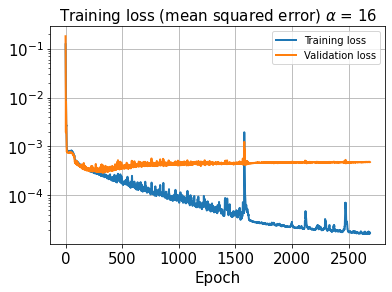

In [37]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.plot(hist['val_loss'], lw=2)
plt.title(r'Training loss (mean squared error) $\alpha$ = 16', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(['Training loss', 'Validation loss'])
plt.grid()
saveName = case_storage + "\\TrainingLoss_val" + str(val_rate) + "test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

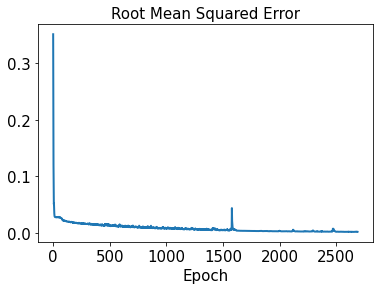

In [38]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

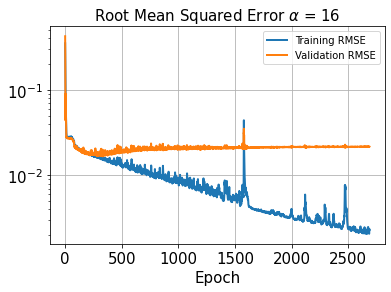

In [39]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title(r'Root Mean Squared Error $\alpha$ = 16', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(['Training RMSE', 'Validation RMSE'])
plt.grid()
saveName = case_storage + "\\RMSE_val" + str(val_rate) + "test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [40]:
test_results = model.evaluate(x_test)

1/1 [==============================] - 0s 128ms/step - loss: 1.2092e-05 - rmse: 0.0000e+00


In [41]:
decoded_train_nor = model.predict(x_train)
decoded_val_nor = model.predict(x_val)
decoded_test_nor = model.predict(x_test)

1/1 [==============================] - 0s 91ms/step


In [42]:
decoded_train = decoded_train_nor*(targetMax-targetMin) + targetMin
decoded_val = decoded_val_nor*(targetMax-targetMin) + targetMin
decoded_test = decoded_test_nor*(targetMax-targetMin) + targetMin

In [43]:
os.chdir("D:\\TrainedModels\\20221101")
model_name = "20221101AeroCNN-II_FlowField_nGrid128_alpha16_val" + str(val_rate) + "test"+str(test_rate)+".h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [44]:
error_train_abs = np.abs(decoded_train - y_train)

In [45]:
error_val_abs = np.abs(decoded_val - y_val)

In [46]:
error_test_abs = np.abs(decoded_test - y_test)

In [47]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.0053124604229834406


In [48]:
l2_error_val = np.sqrt(np.sum((decoded_val - y_val)**2) / np.sum(y_val**2))
print(l2_error_val)

0.053089869332056186


In [49]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.06461246459084229


In [50]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [51]:
l2_error_val_list = []
for i in range(0, len(aa_val)):
    l2_error_val_data = np.sqrt(np.sum((decoded_val[i] - y_val[i])**2) / np.sum(y_val[i]**2))
    l2_error_val_list.append(l2_error_val_data)

In [52]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

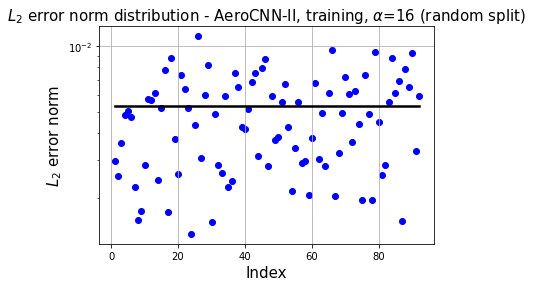

In [64]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title(r'$L_2$ error norm distribution - AeroCNN-II, training, $\alpha$=16 (random split)', fontsize=15)
plt.grid()
saveName = case_storage + "\\trainingErrorDistribution"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)

plt.show()

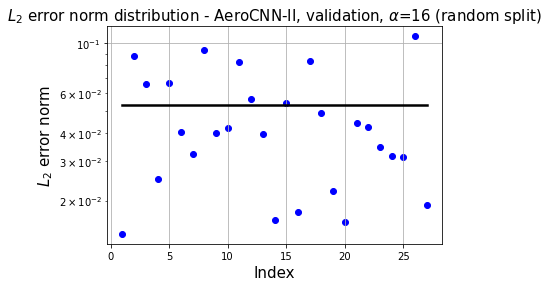

In [65]:
plt.plot(np.linspace(1, aa_val.shape[0], aa_val.shape[0]),
         l2_error_val*np.ones(aa_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_val.shape[0], aa_val.shape[0]), l2_error_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title(r'$L_2$ error norm distribution - AeroCNN-II, validation, $\alpha$=16 (random split)', fontsize=15)
plt.grid()
saveName = case_storage + "\\validationErrorDistribution"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

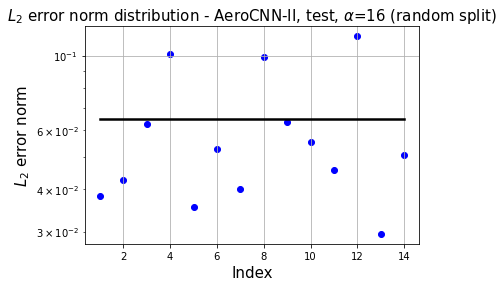

In [66]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title(r'$L_2$ error norm distribution - AeroCNN-II, test, $\alpha$=16 (random split)', fontsize=15)
plt.grid()
saveName = case_storage + "\\testErrorDistribution"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

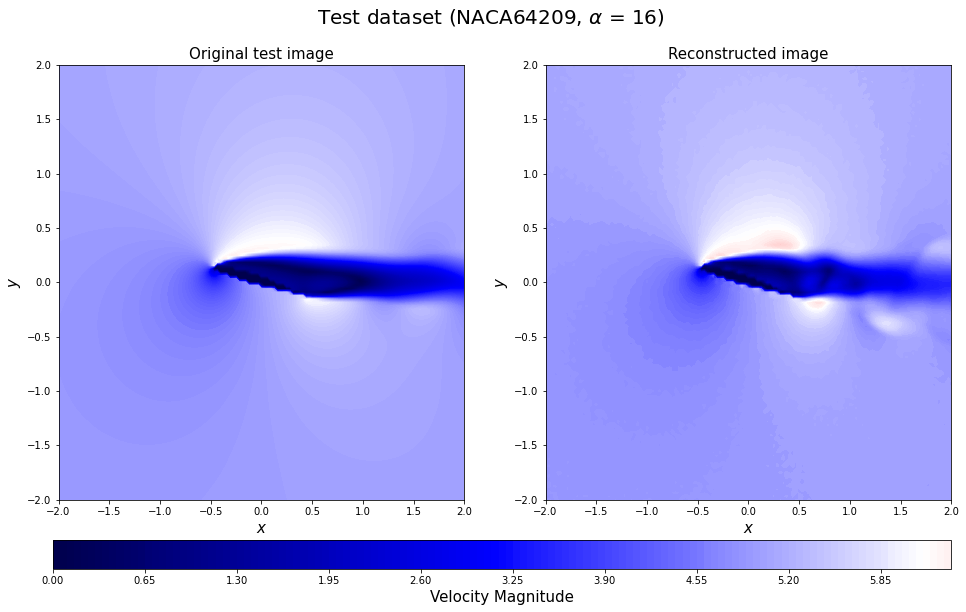

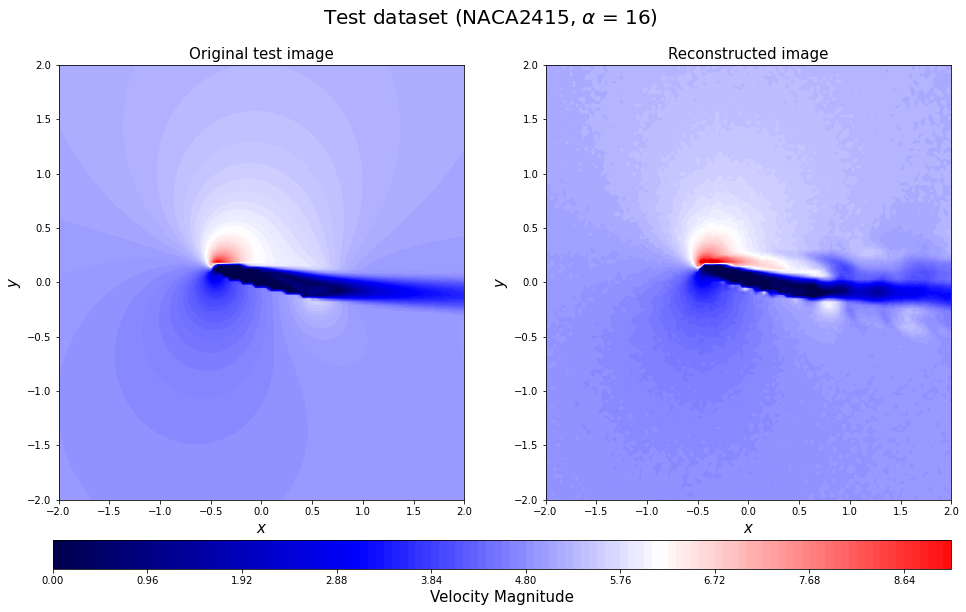

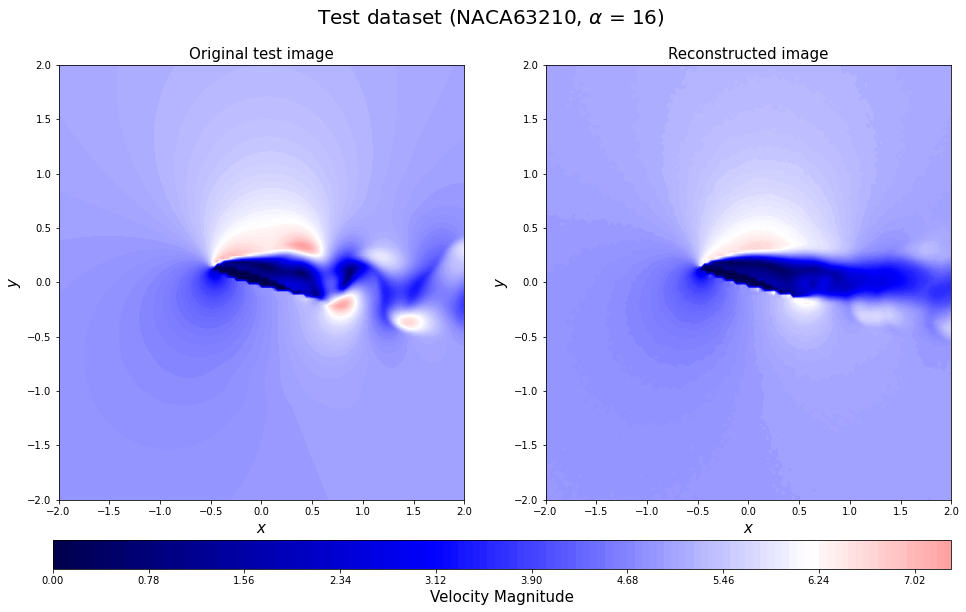

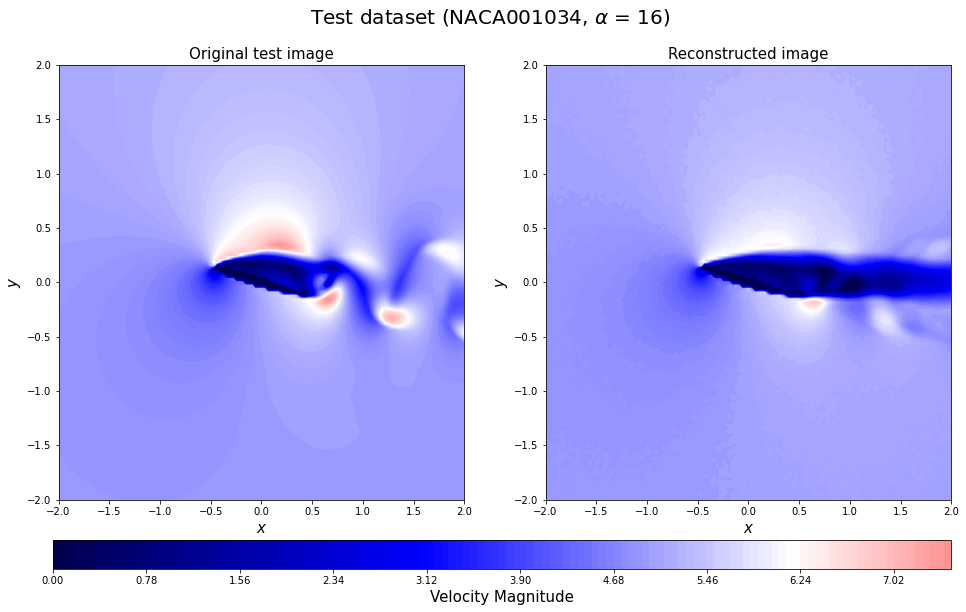

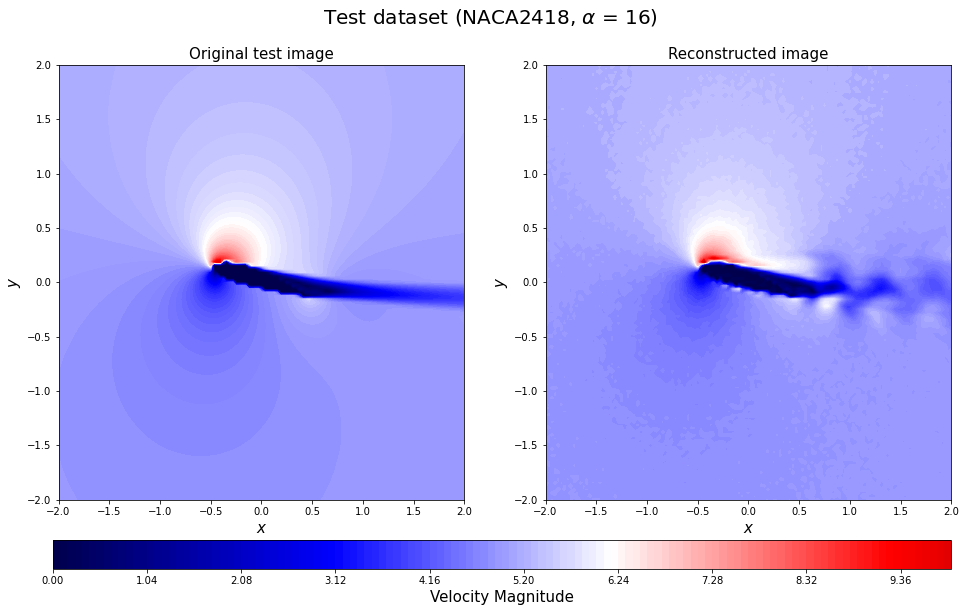

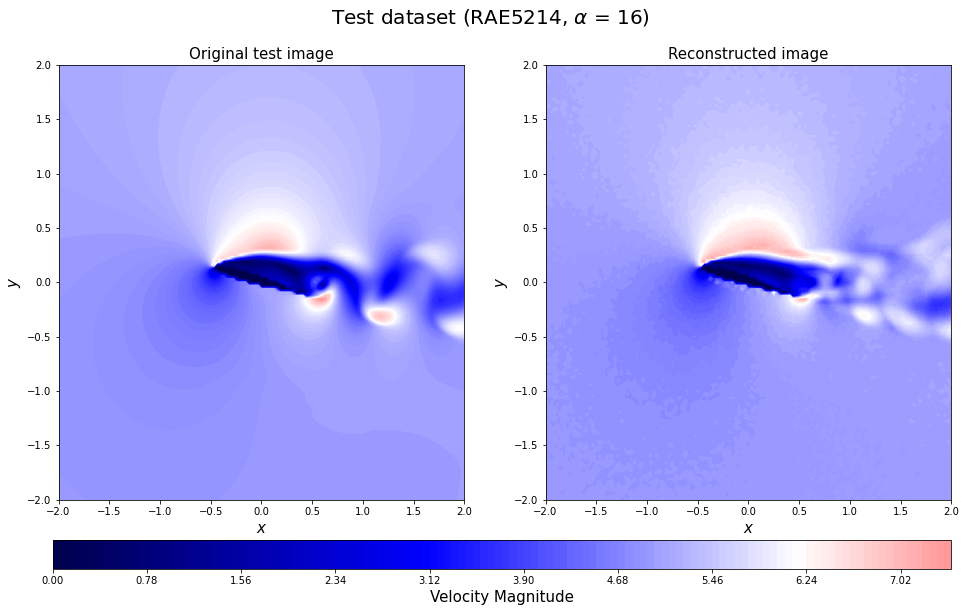

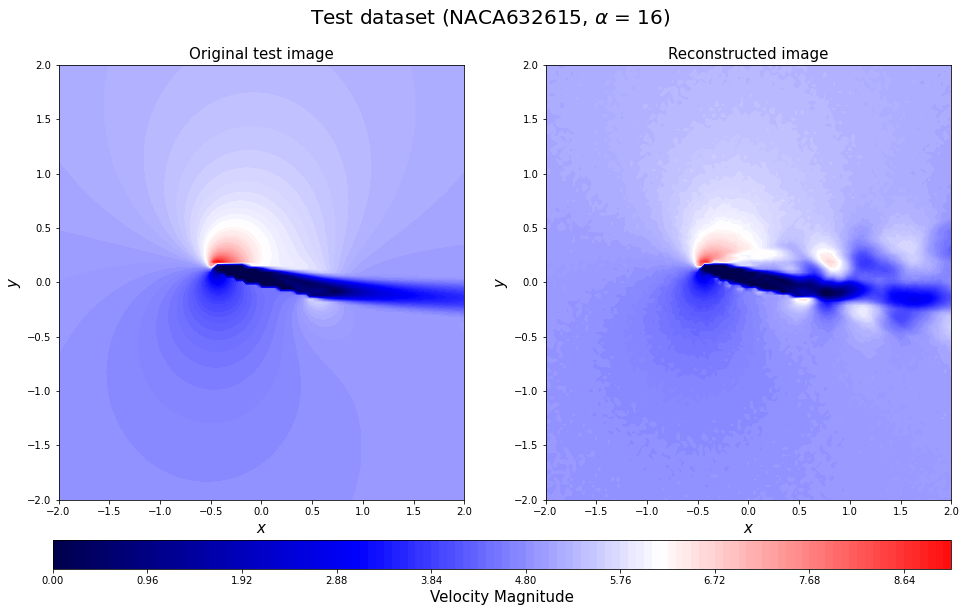

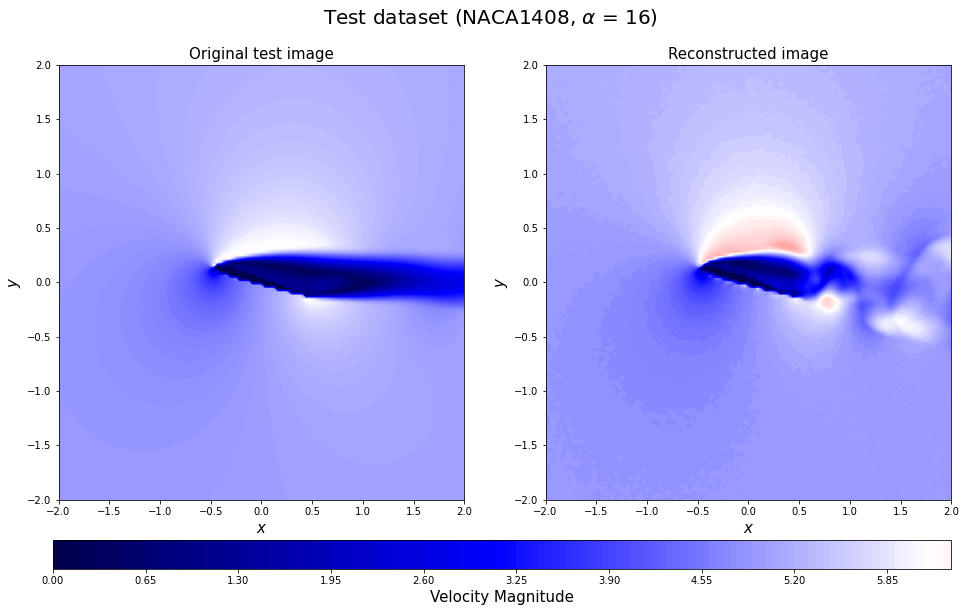

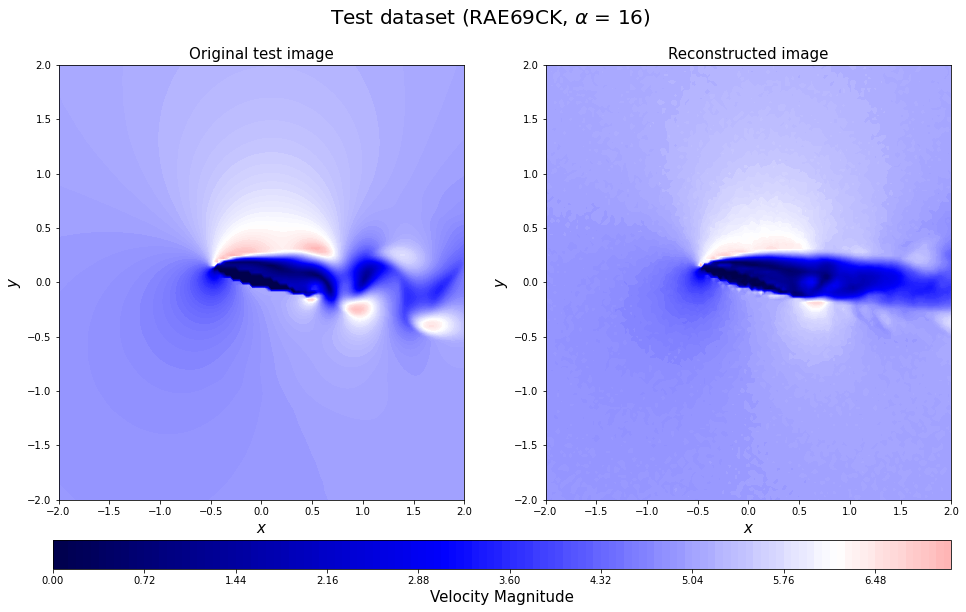

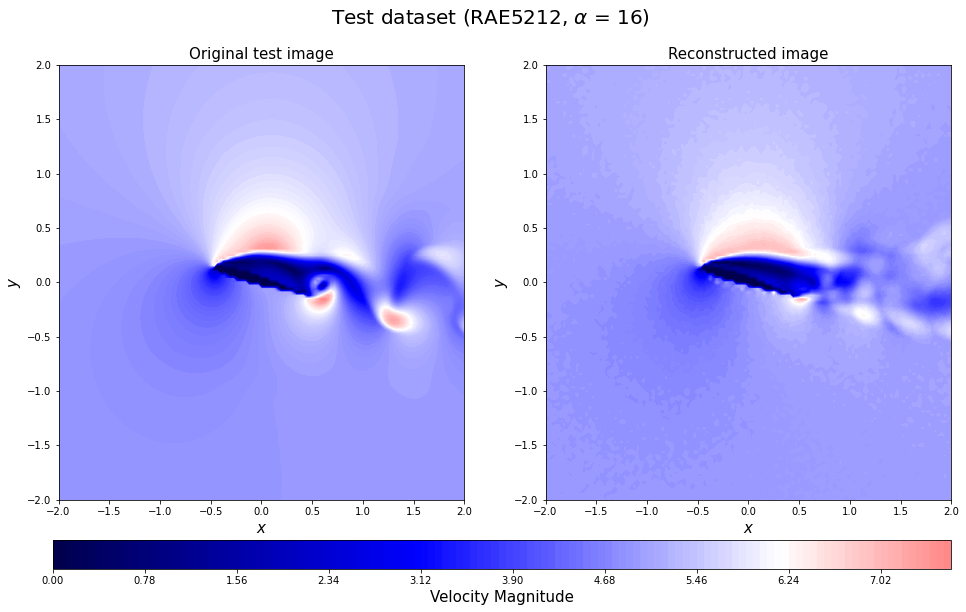

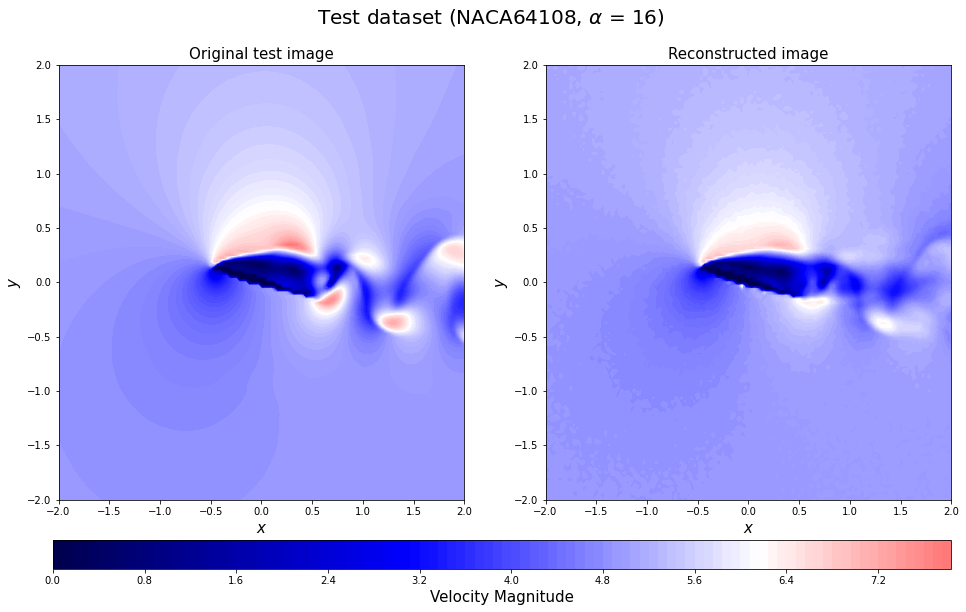

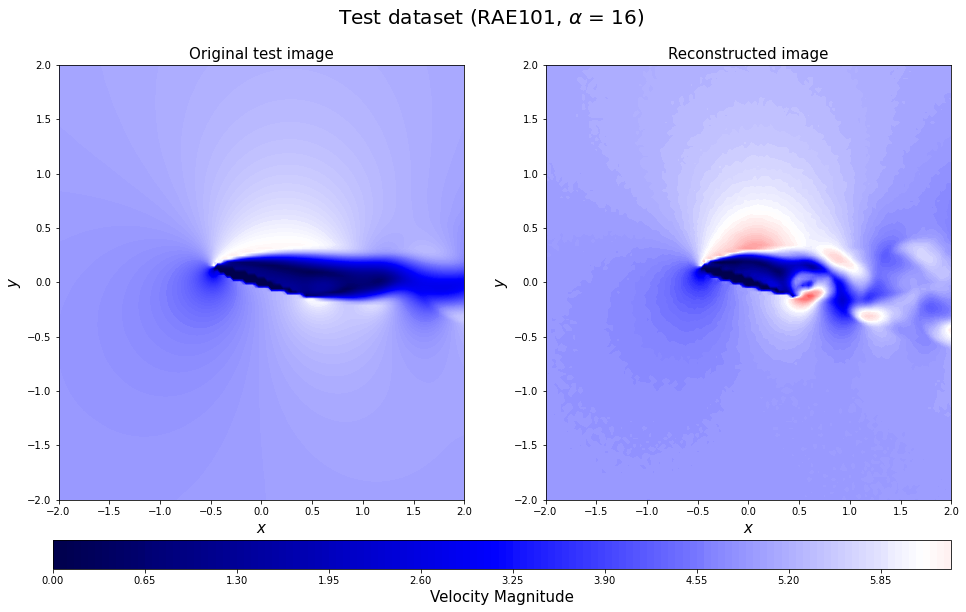

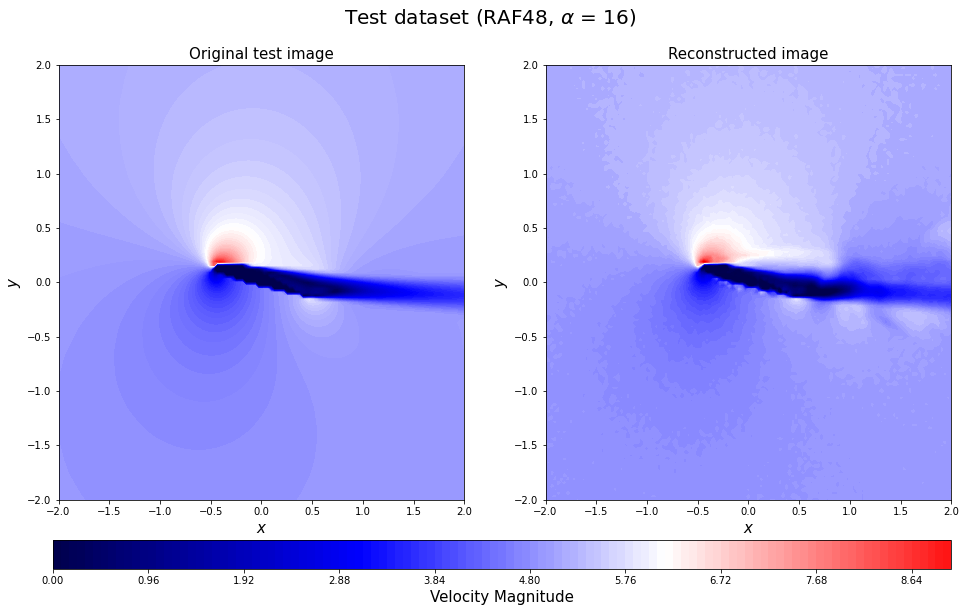

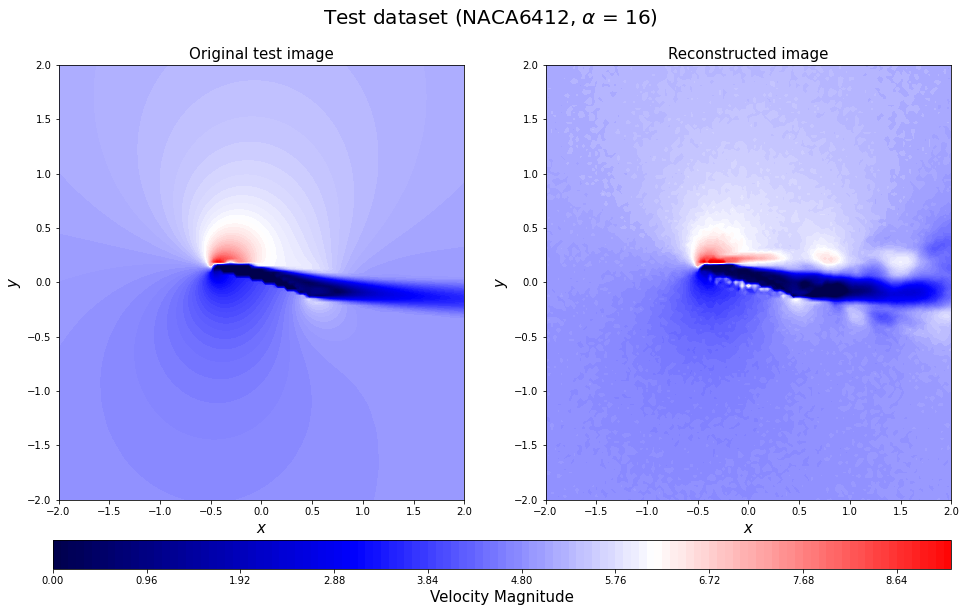

In [67]:
n_grid =129
for c in range(0,14):
    plt.figure(figsize=(16, 8))
    y_test2_rotate = y_test[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_test[c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_test2_rotate, vmin=targetMin, vmax=targetMax, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=targetMin, vmax=targetMax, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test[c])[3:-2], aa_test[c]),fontsize=20)
    saveName = case_storage + "\\testprediction"+str(np.array2string(geo_test[c])[3:-2])+"_alpha"+str(aa_test[c])+".jpg"
    plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

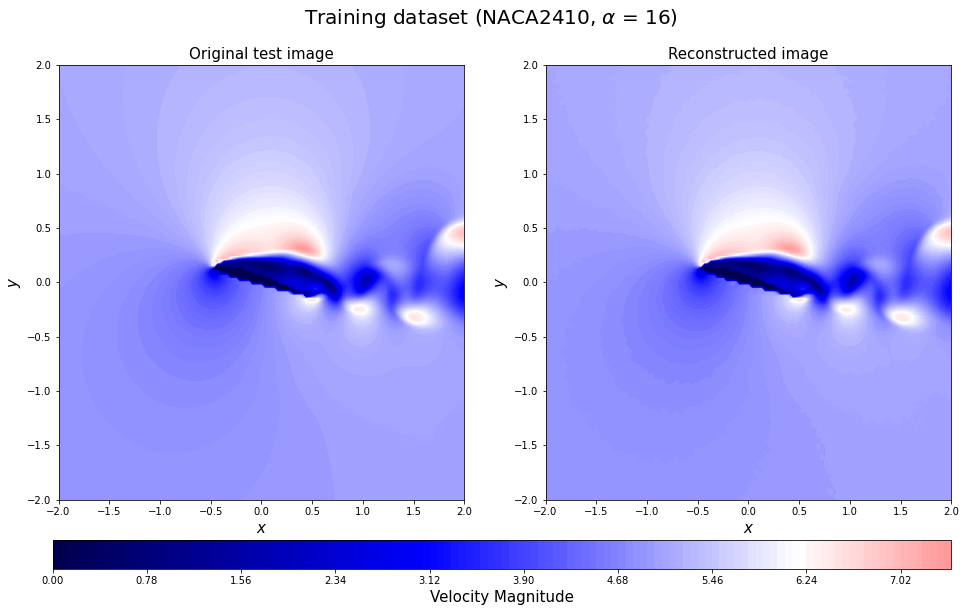

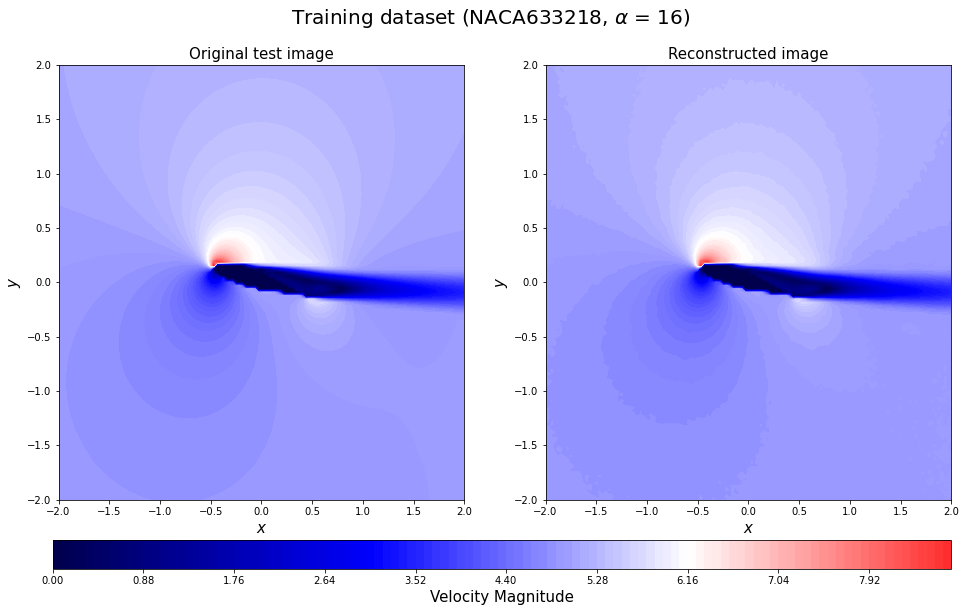

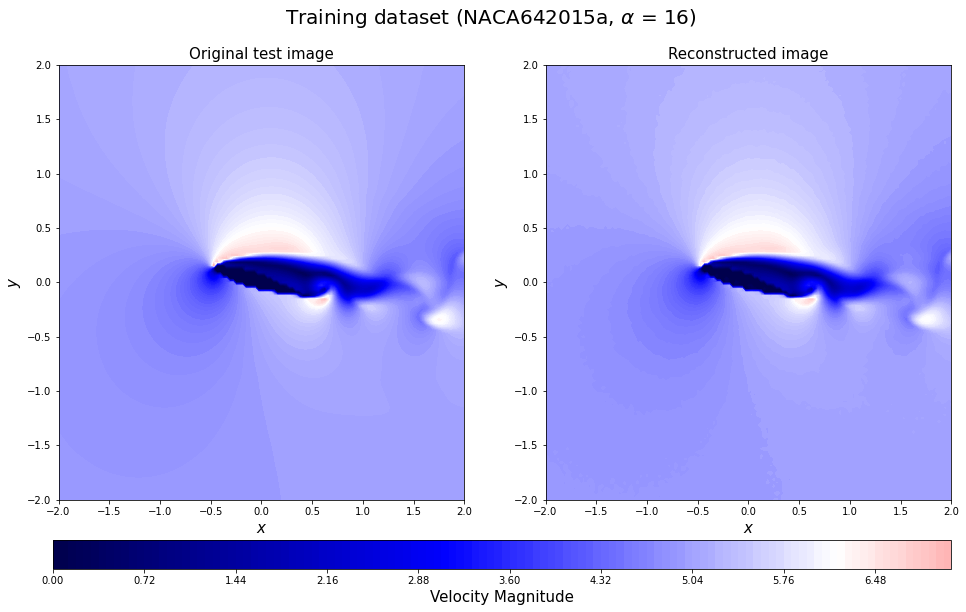

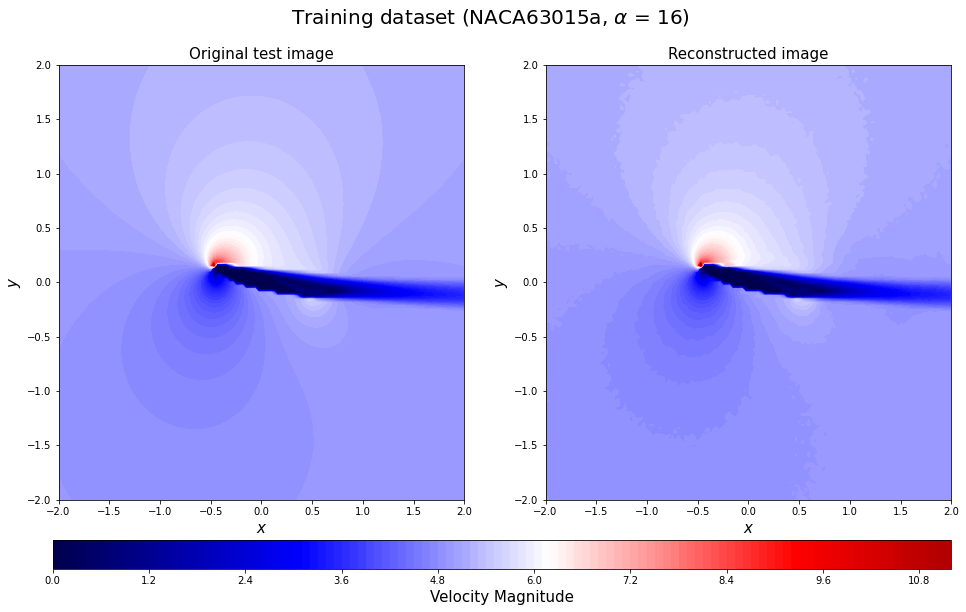

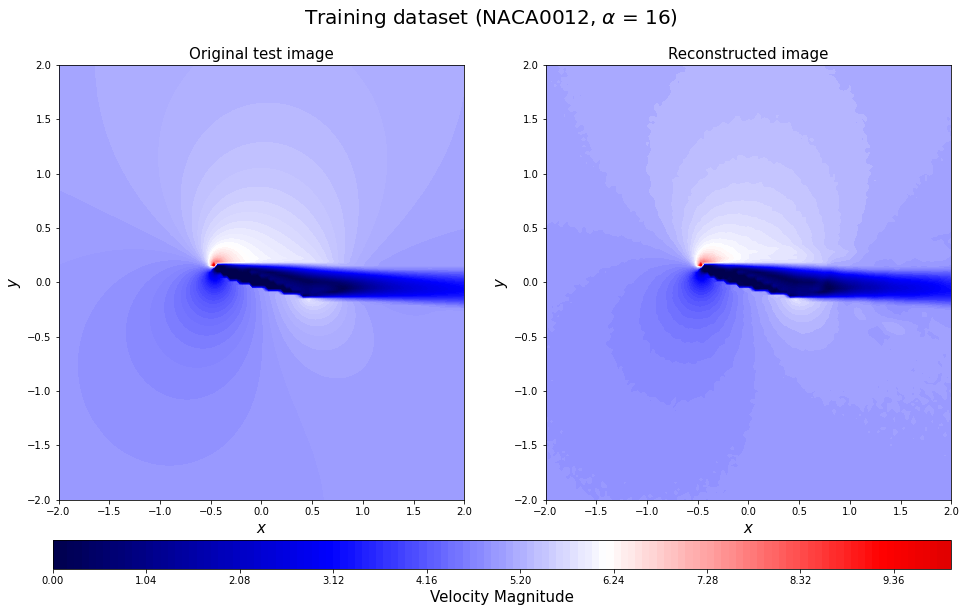

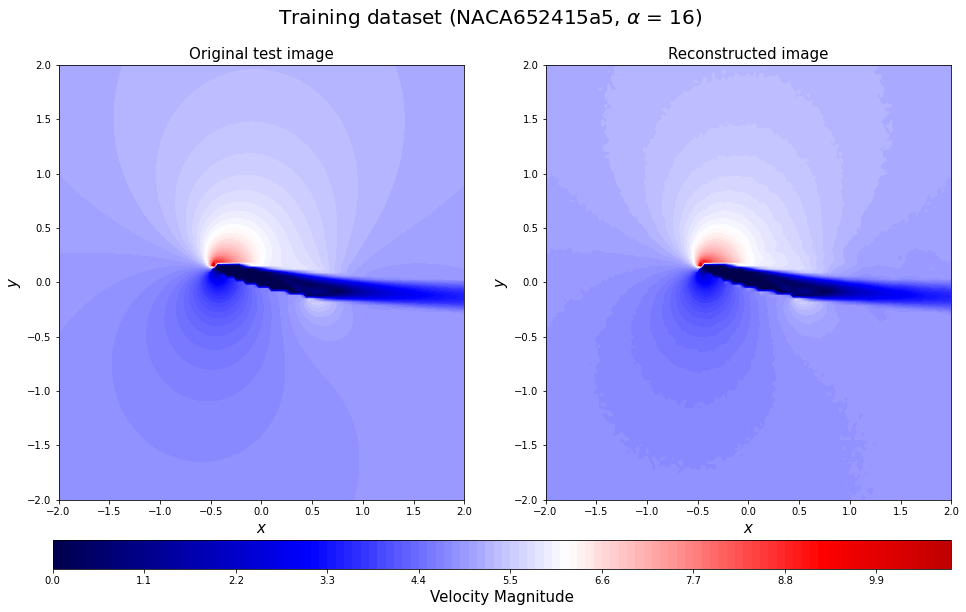

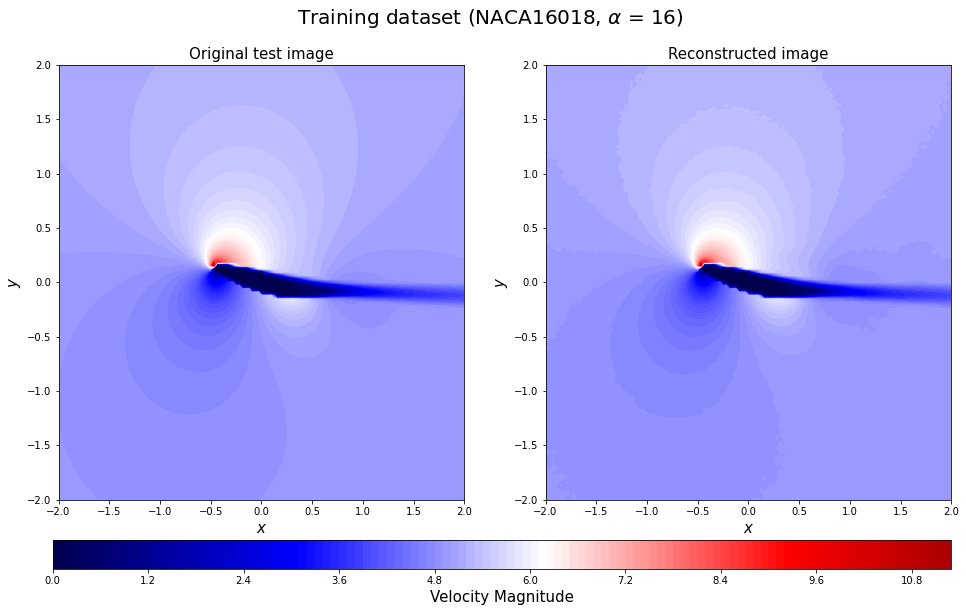

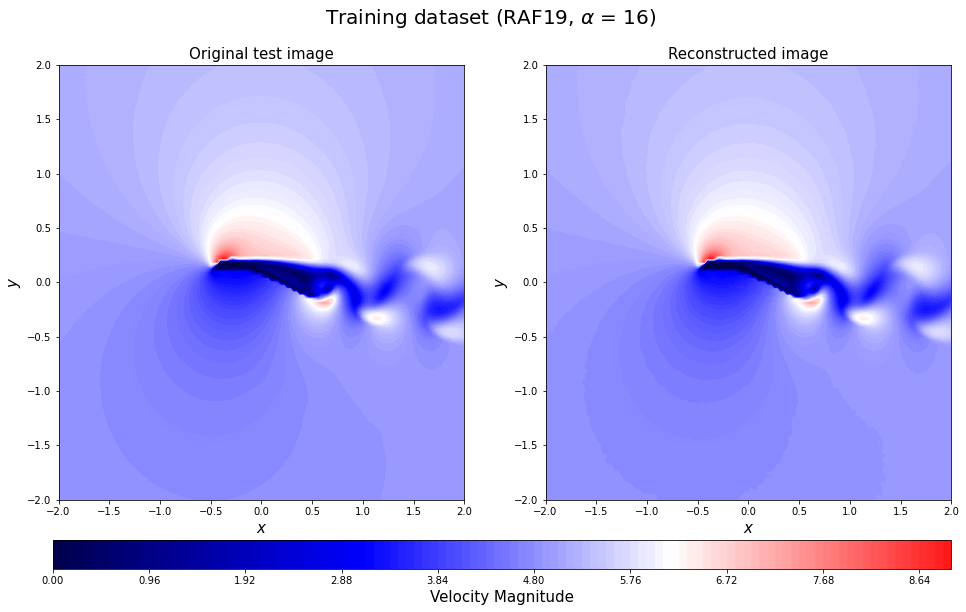

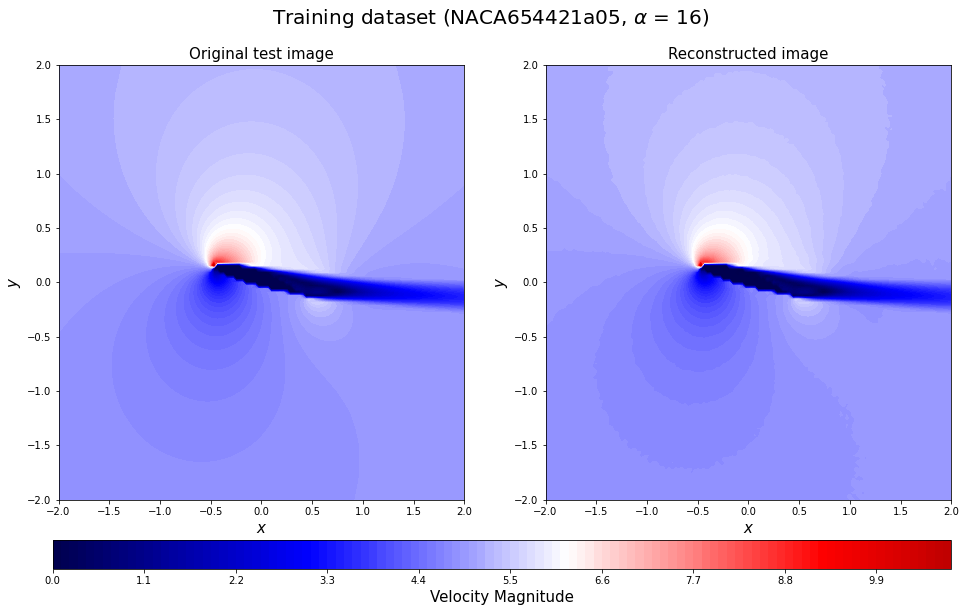

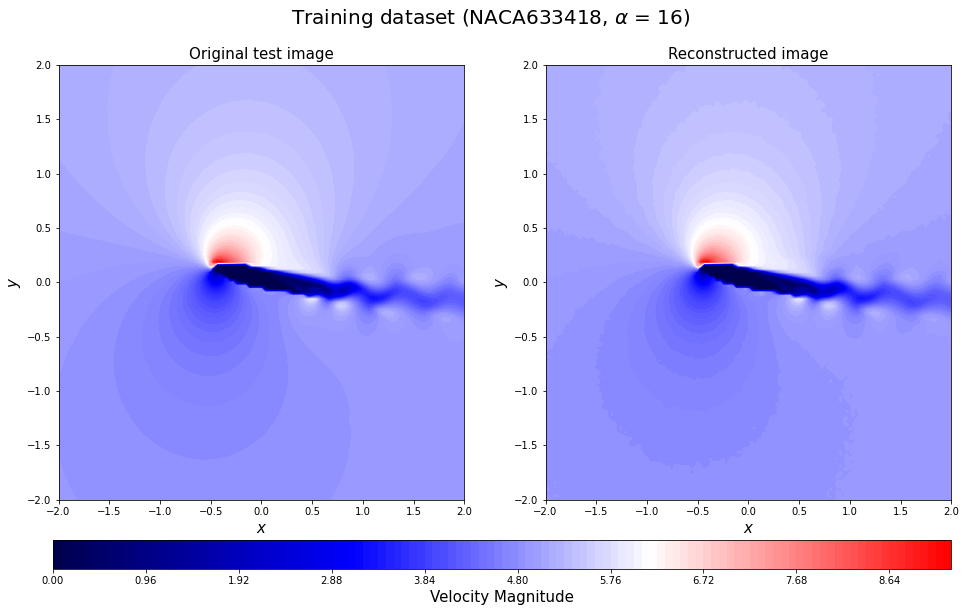

In [68]:
for c in range(0,10):
    plt.figure(figsize=(16, 8))
    y_train0_rotate = y_train[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_train[c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_train0_rotate, vmin=targetMin, vmax=targetMax, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=targetMin, vmax=targetMax, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Training dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_train[c])[3:-2], aa_train[c]),fontsize=20)
    saveName = case_storage + "\\trainingprediction"+str(np.array2string(geo_train[c])[3:-2])+"_alpha"+str(aa_train[c])+".jpg"
    plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

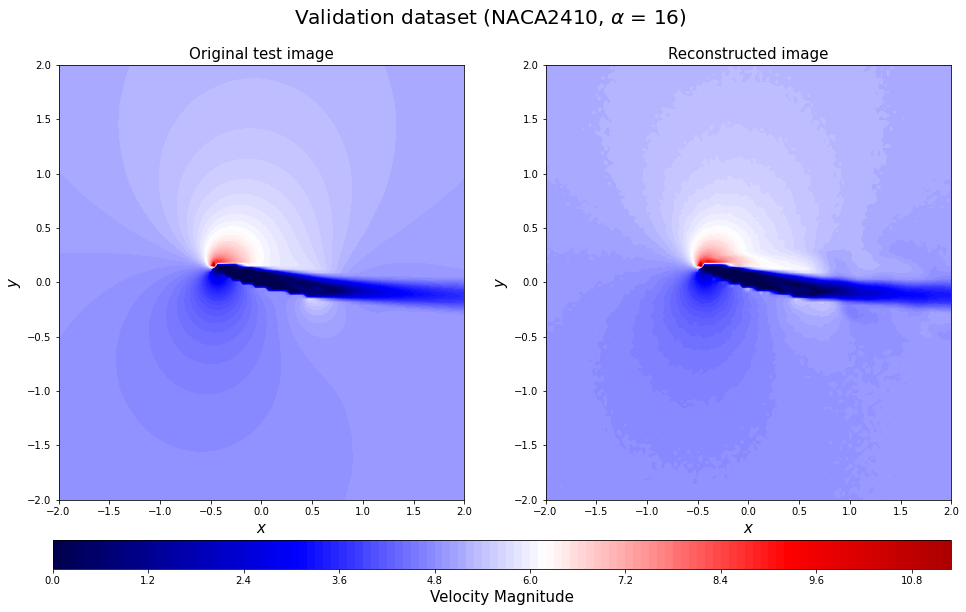

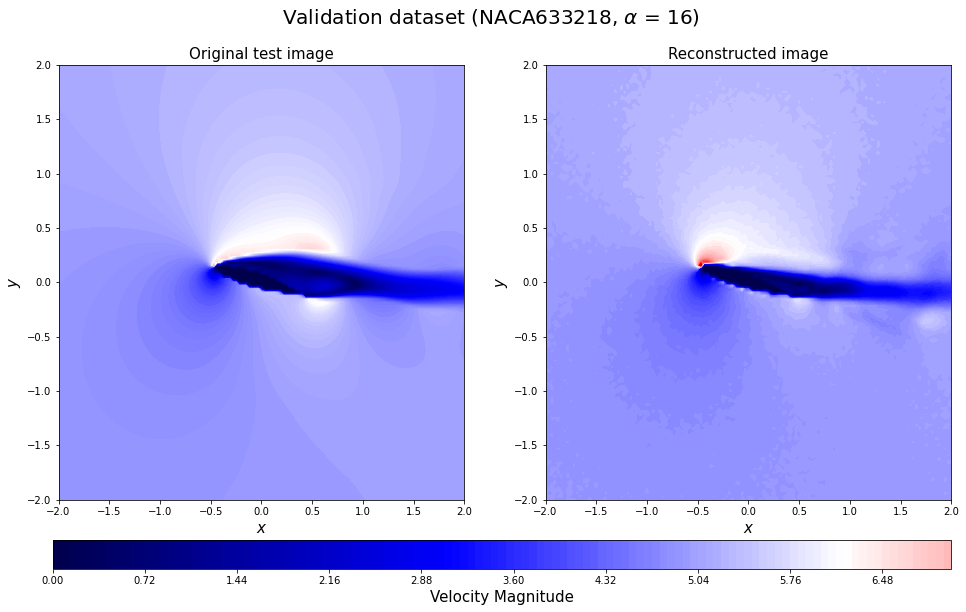

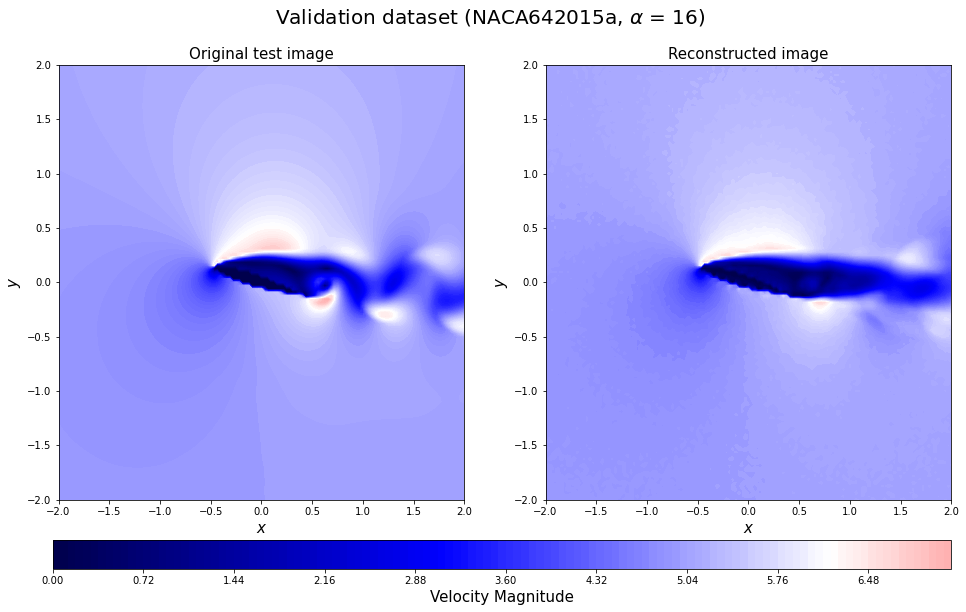

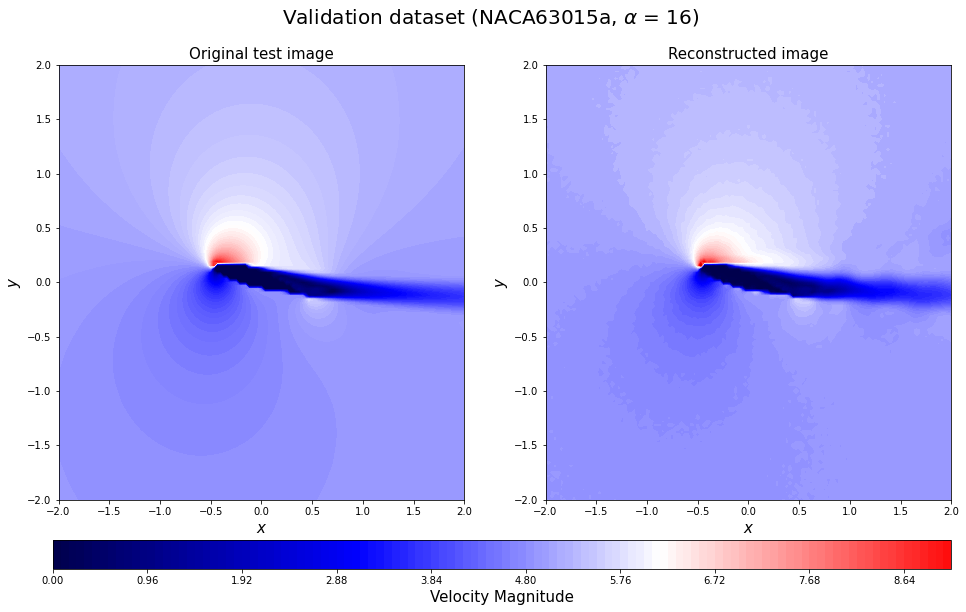

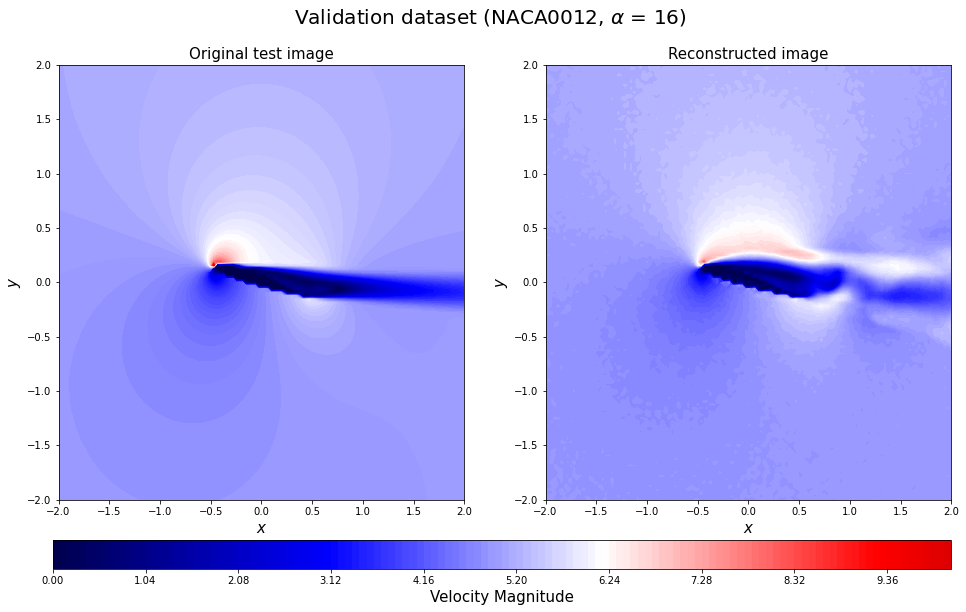

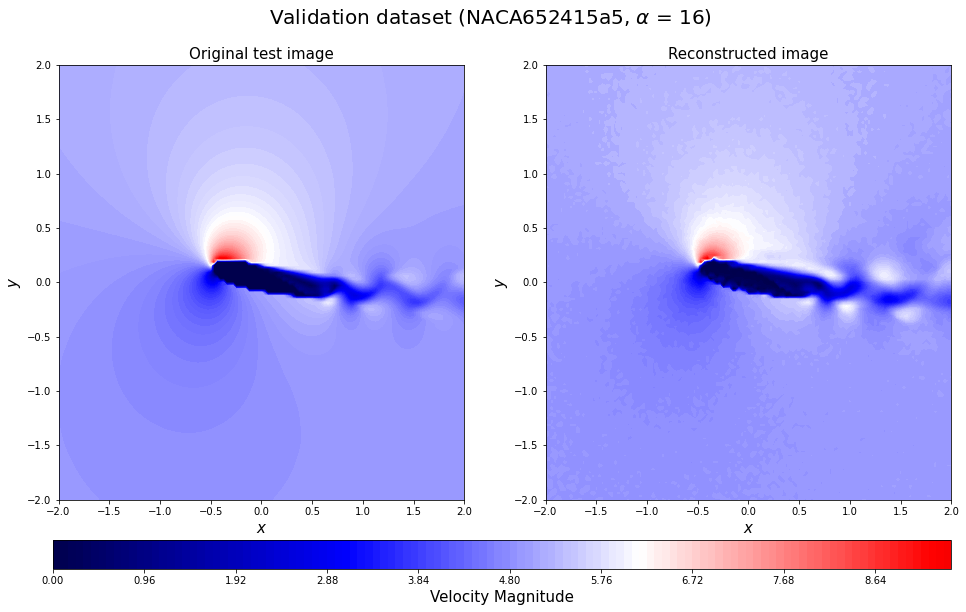

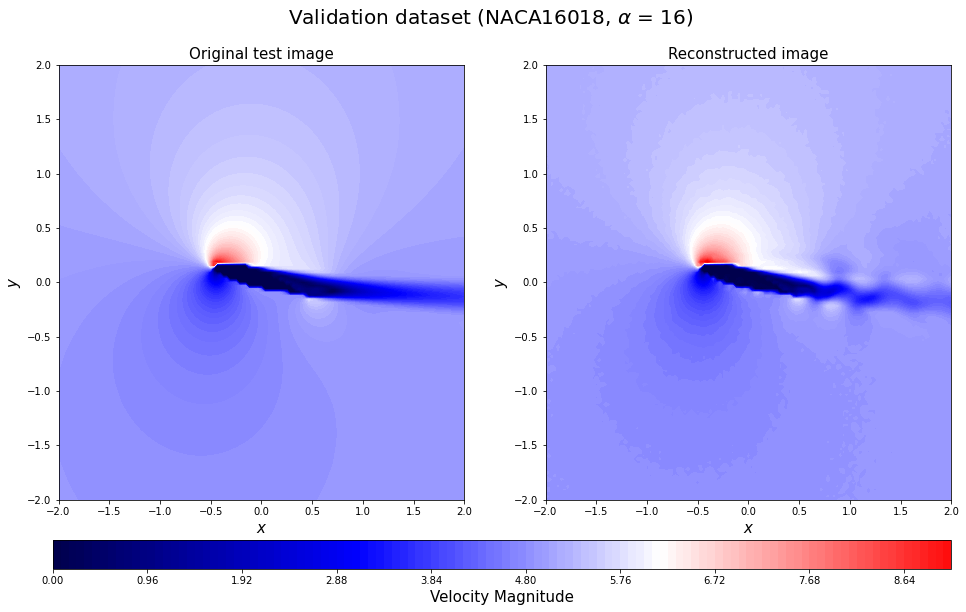

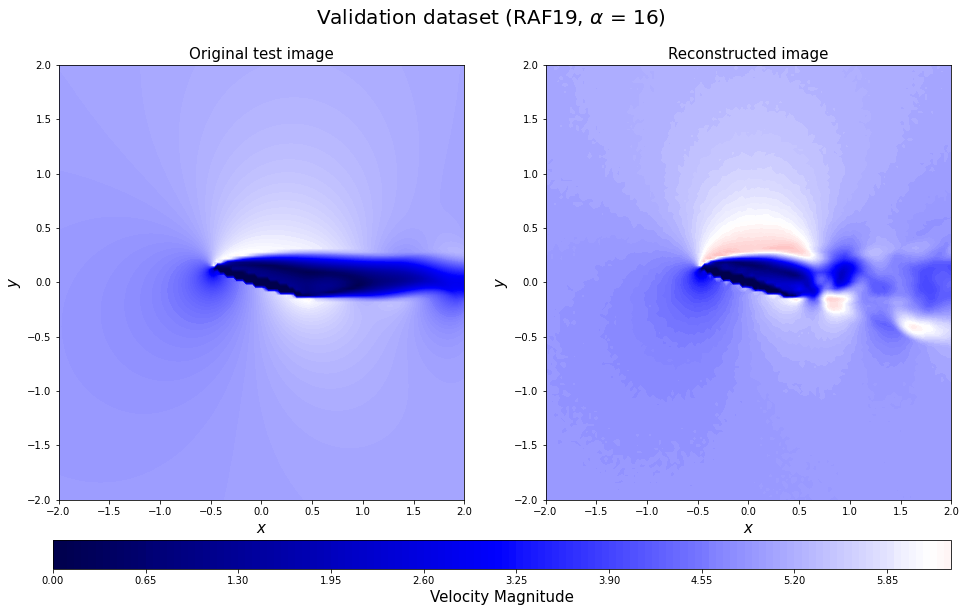

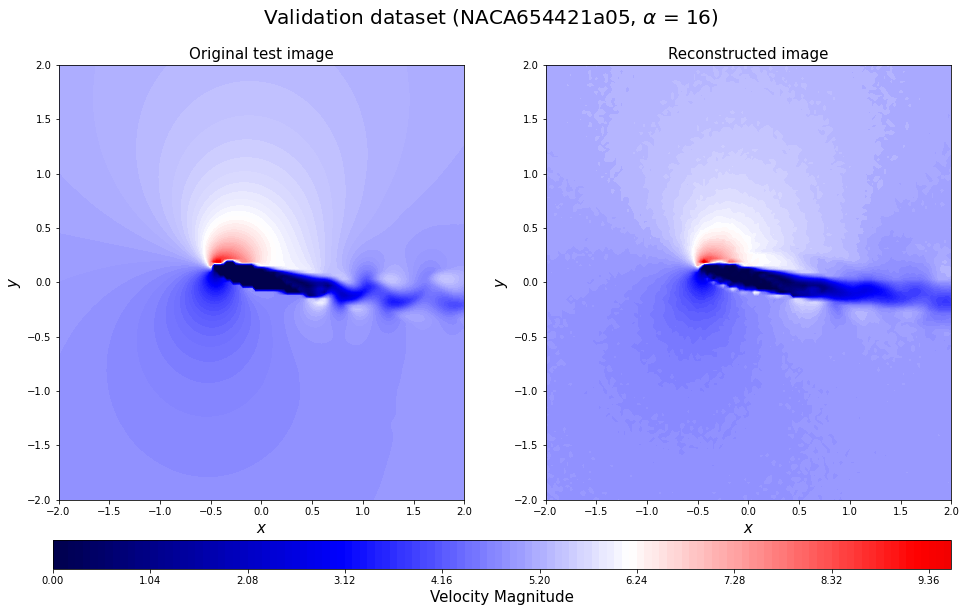

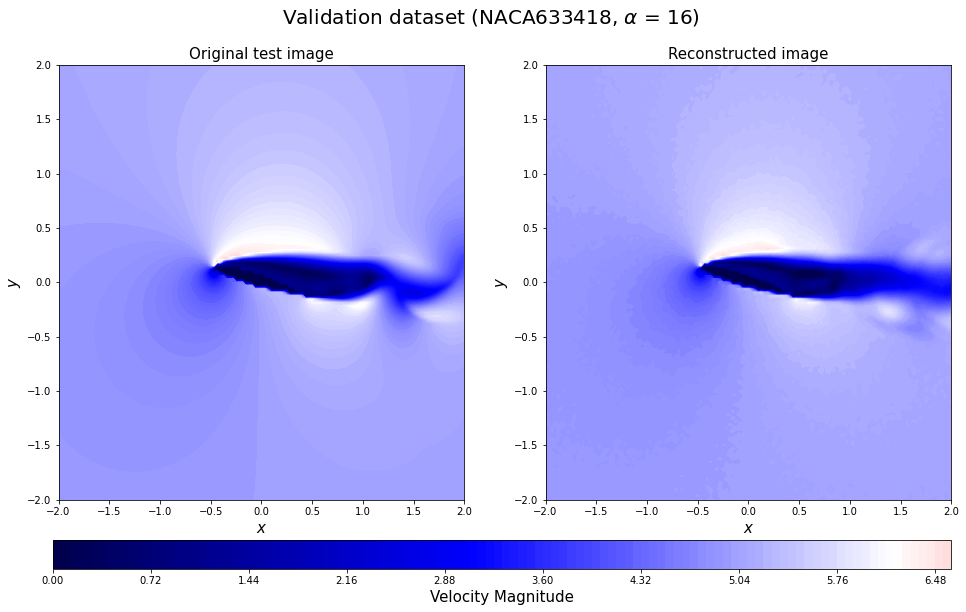

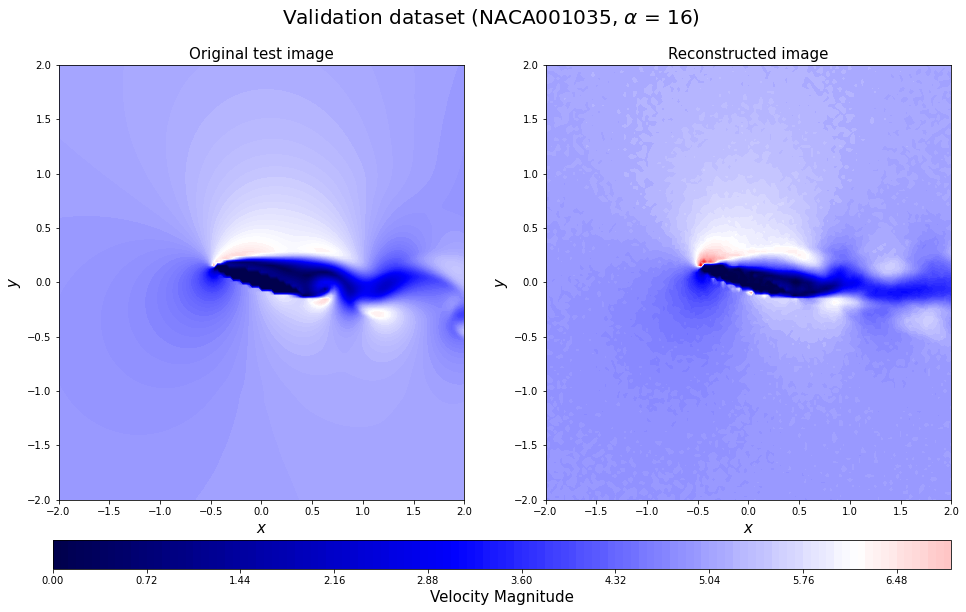

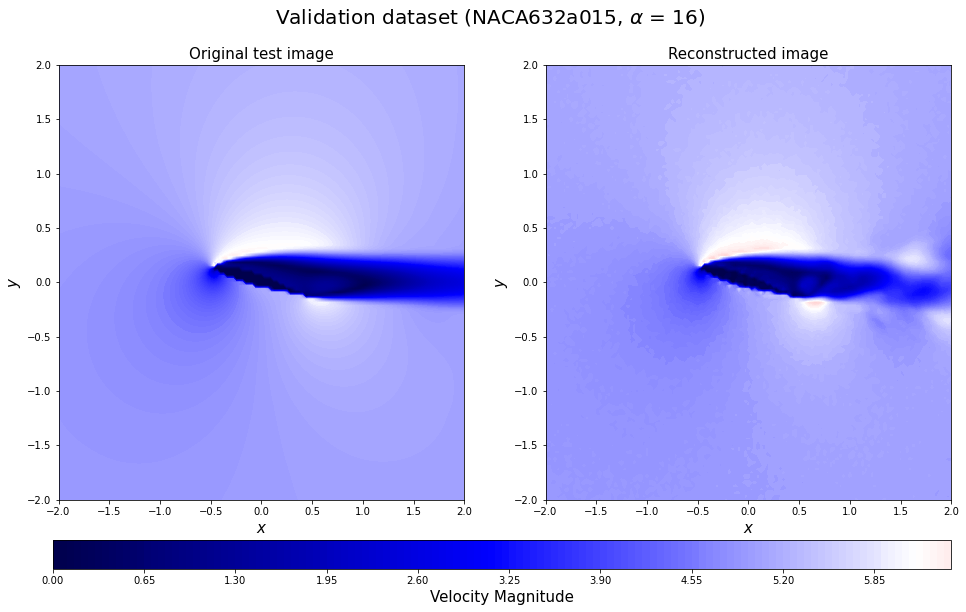

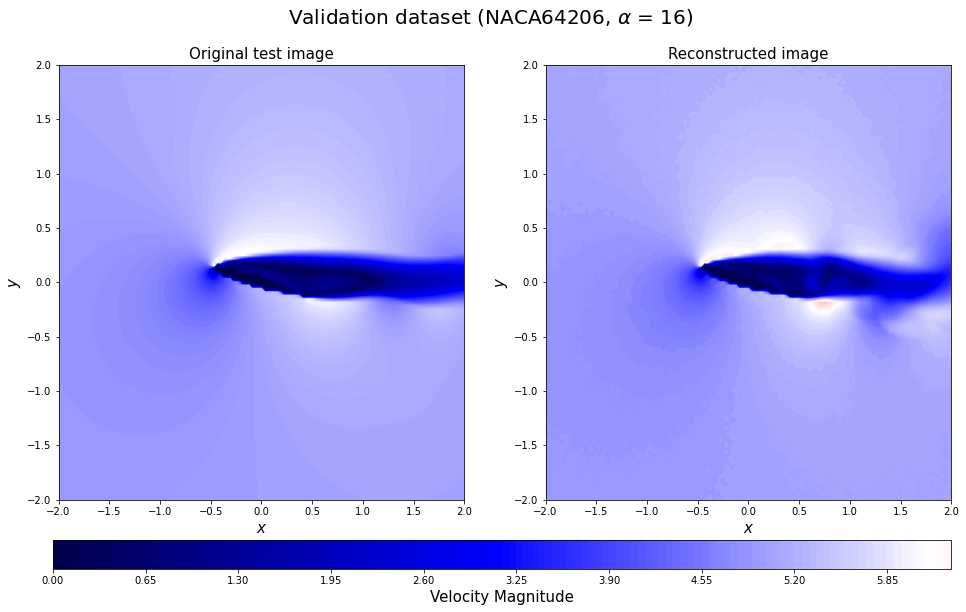

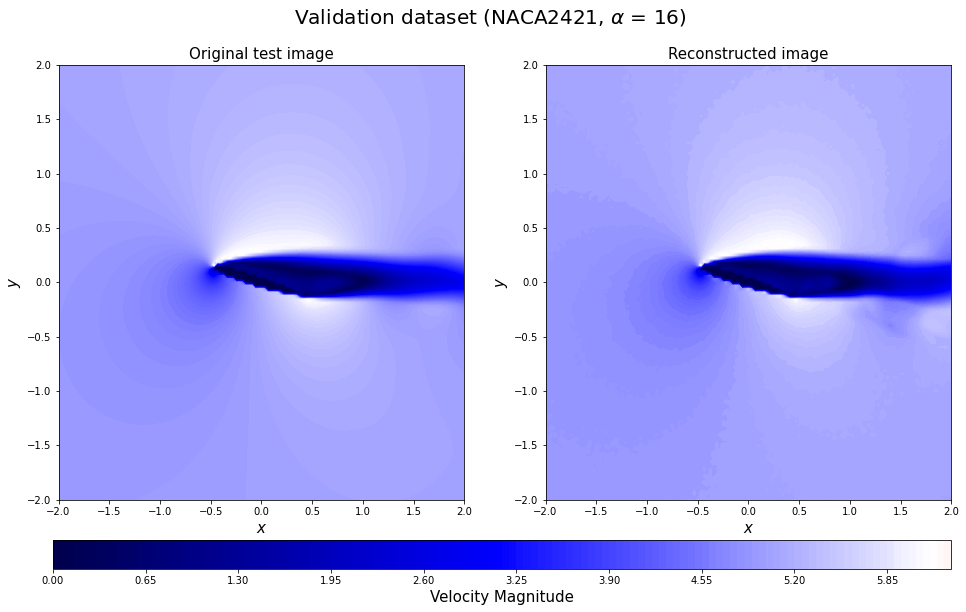

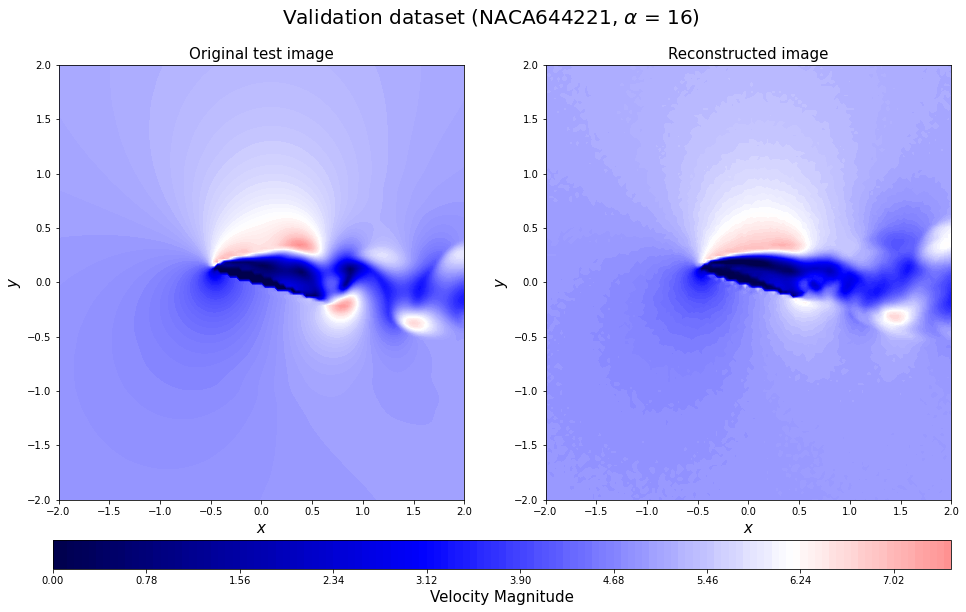

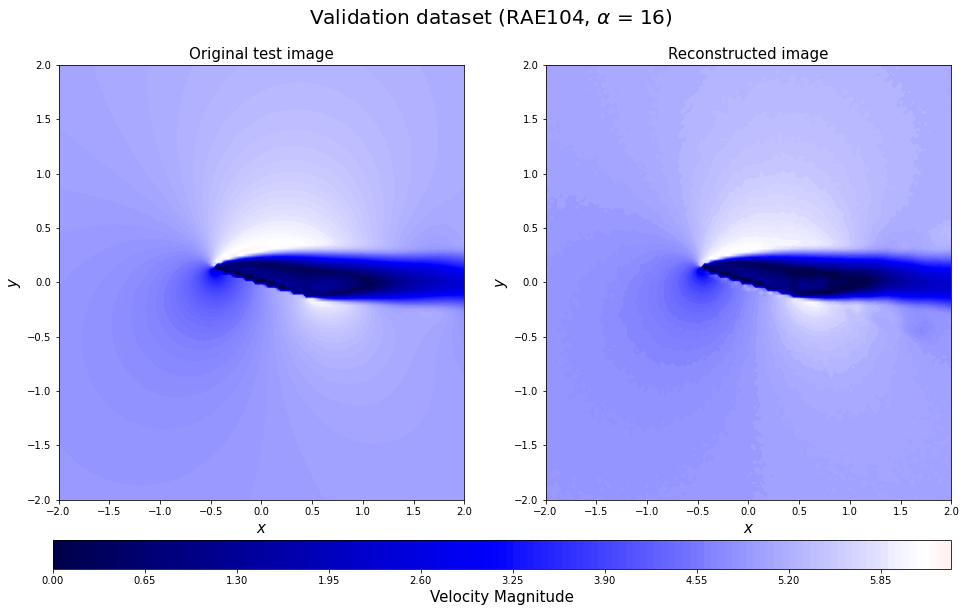

In [69]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_val20_rotate = y_val[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_val[c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_val20_rotate, vmin=targetMin, vmax=targetMax, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=targetMin, vmax=targetMax, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Validation dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_train[c])[3:-2], aa_train[c]),fontsize=20)
    saveName = case_storage + "\\validationprediction"+str(np.array2string(geo_val[c])[3:-2])+"_alpha"+str(aa_val[c])+".jpg"
    plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

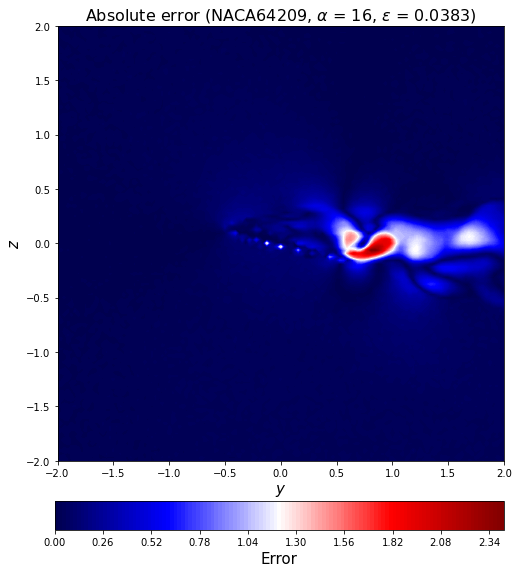

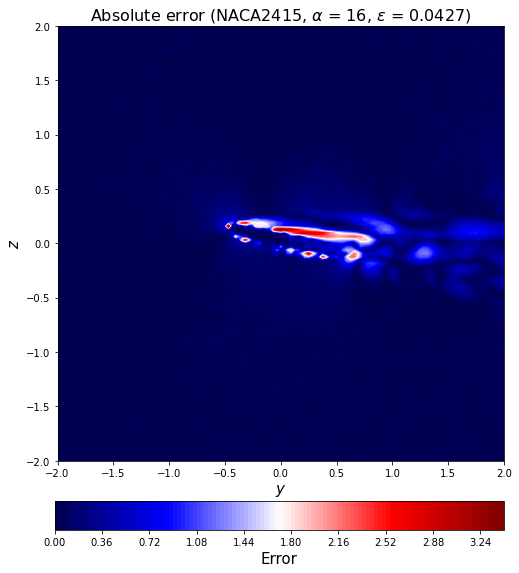

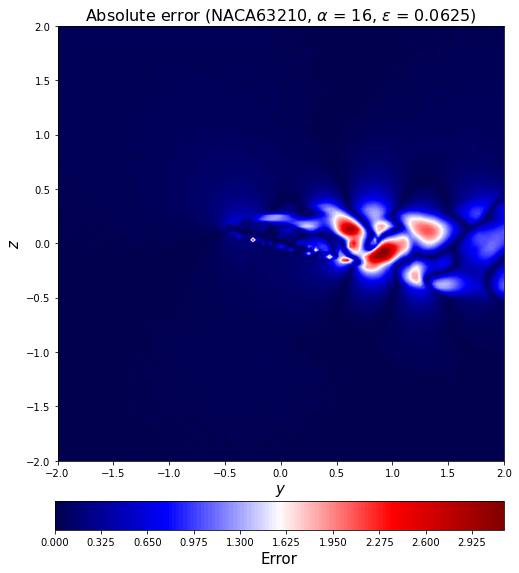

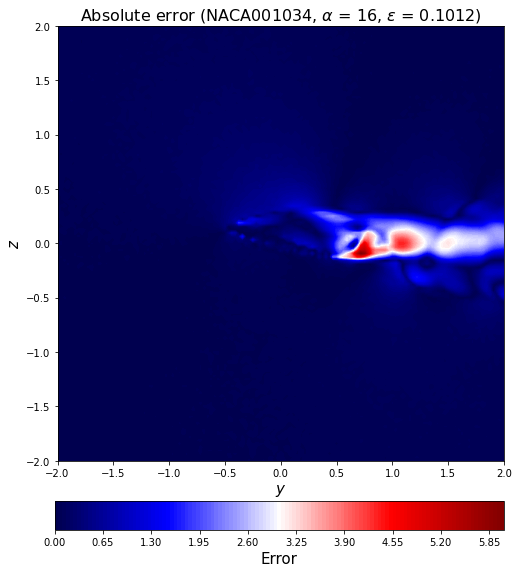

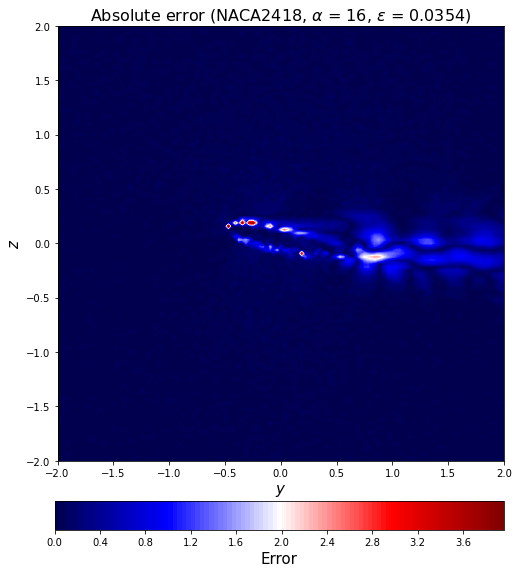

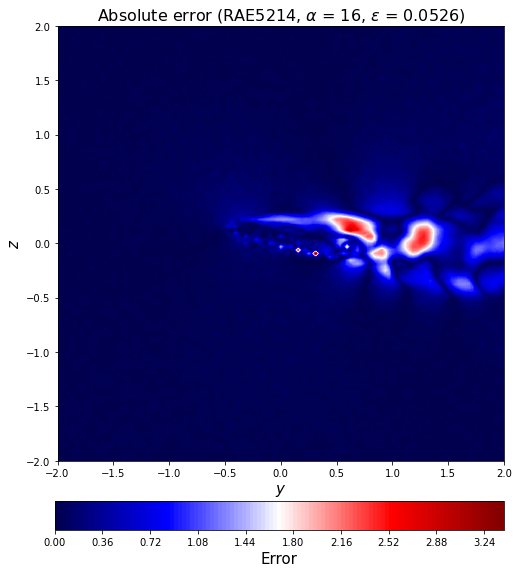

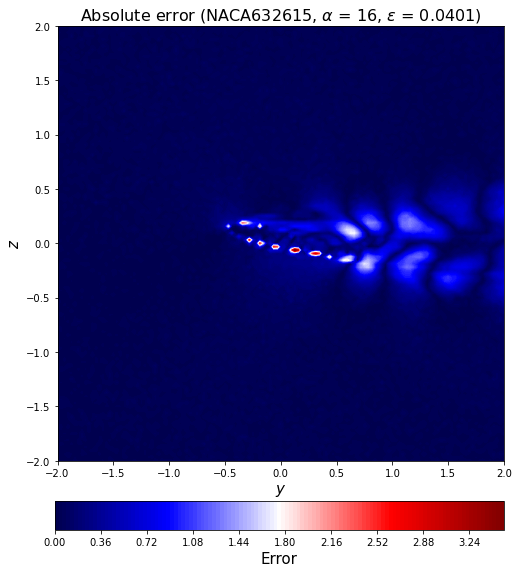

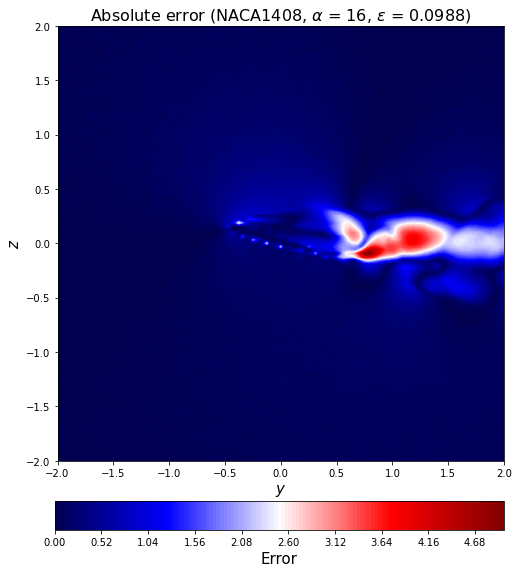

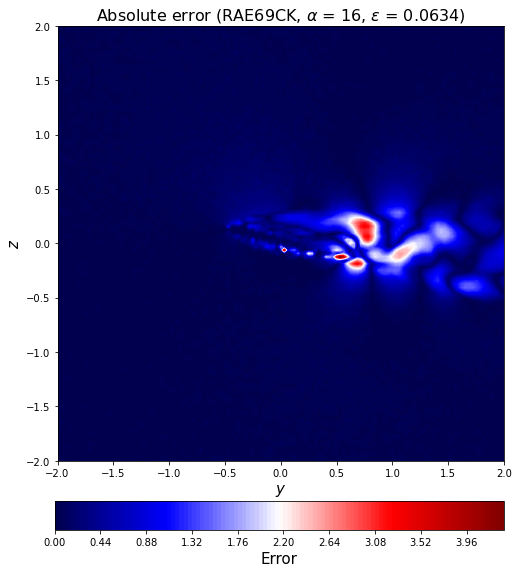

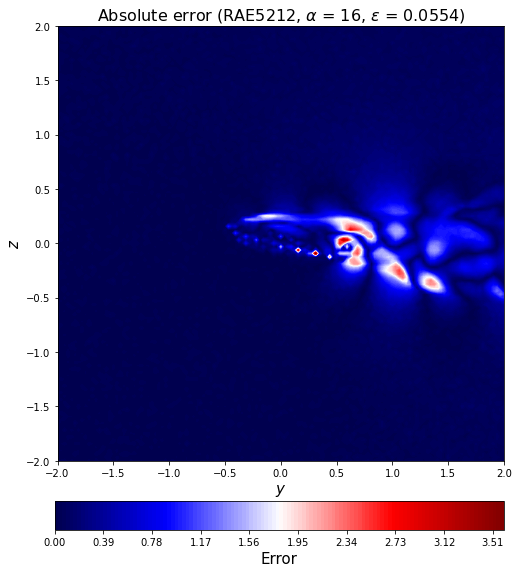

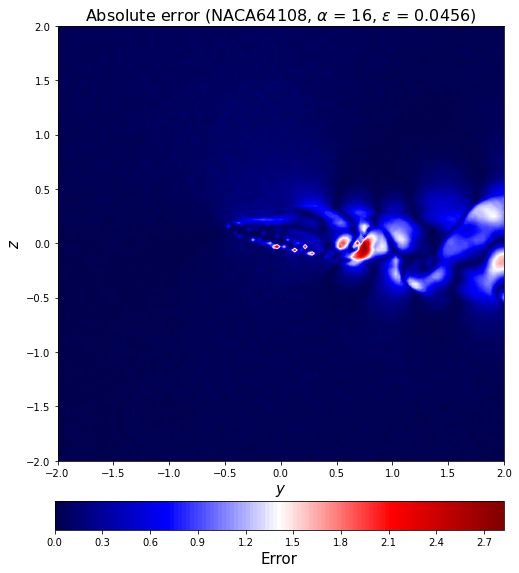

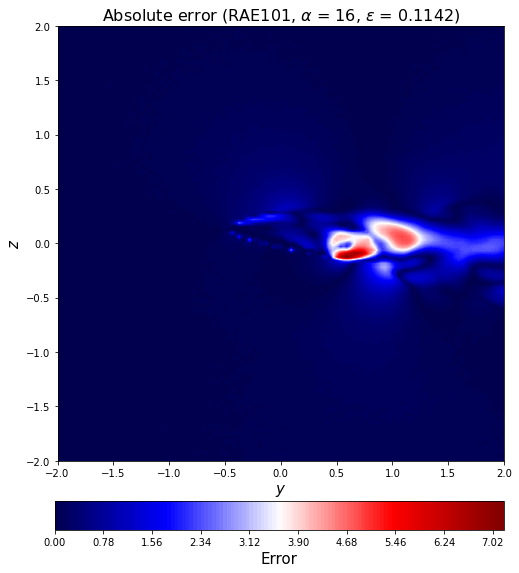

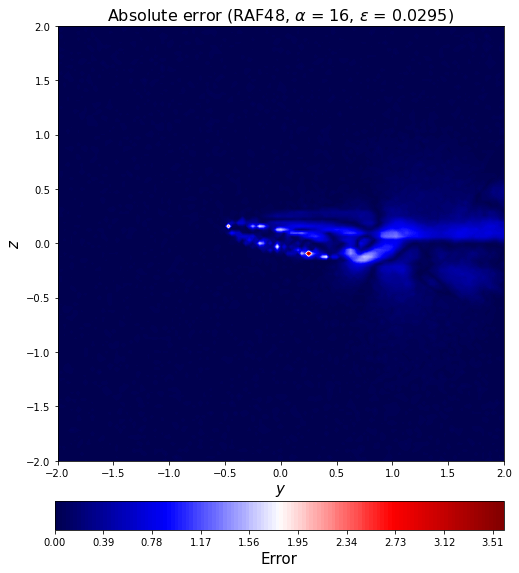

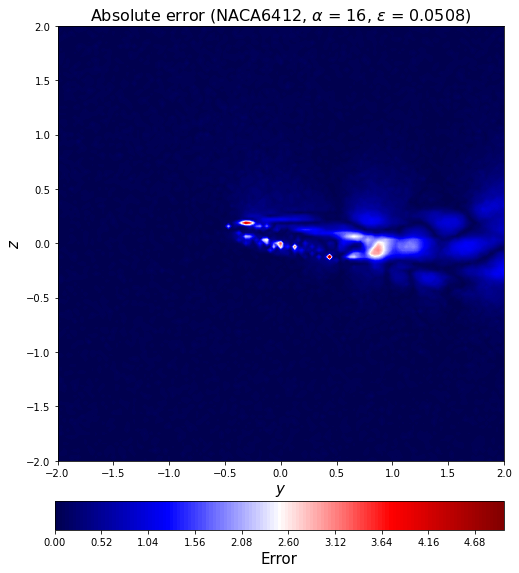

In [70]:
for c in range(0,14):
    error_test_abs2_rotate = error_test_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test[c])[3:-2],
                                                                       aa_test[c], l2_error_test_list[c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    saveName = case_storage+ "\\testError"+str(np.array2string(geo_test[c])[3:-2])+"_alpha"+str(aa_test[c])+".jpg"
    plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

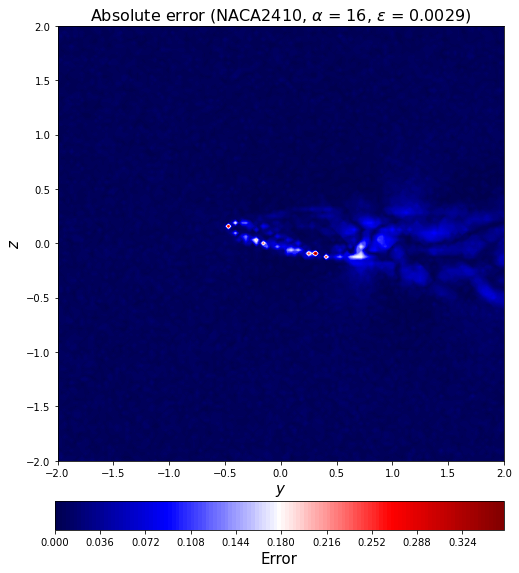

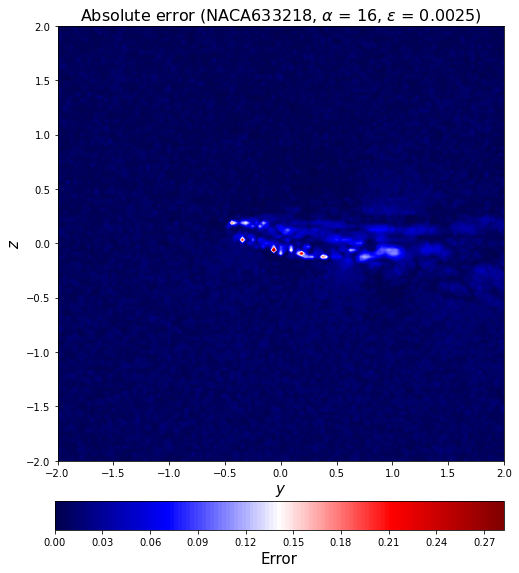

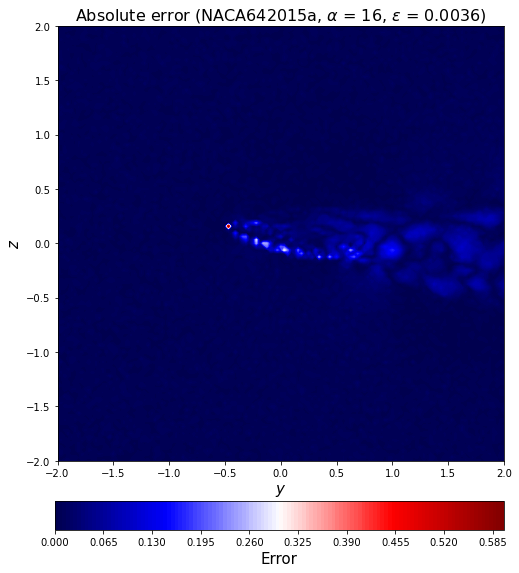

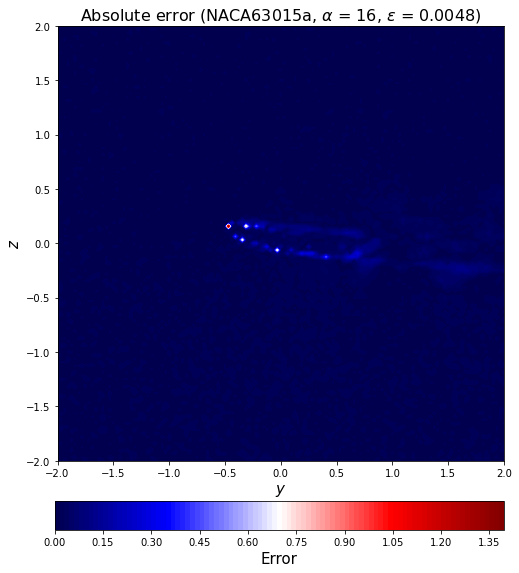

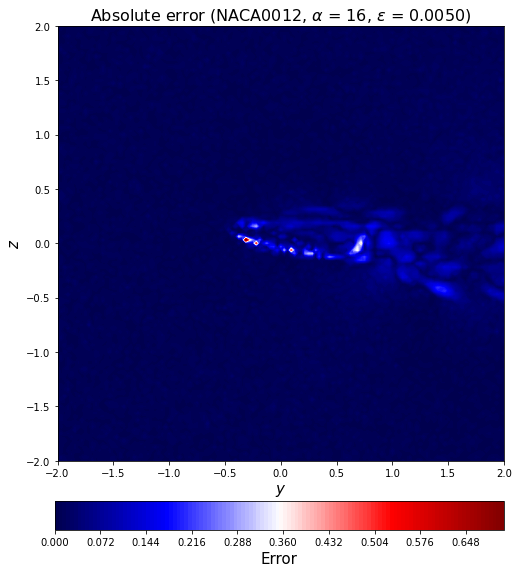

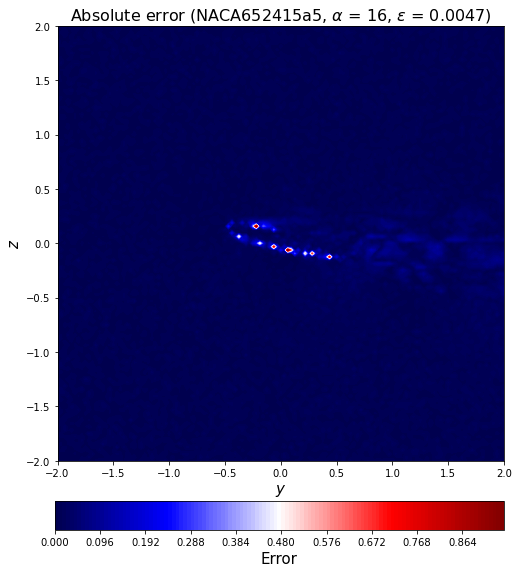

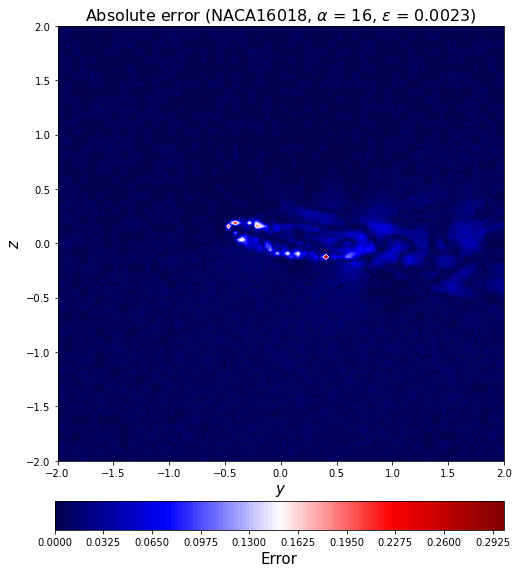

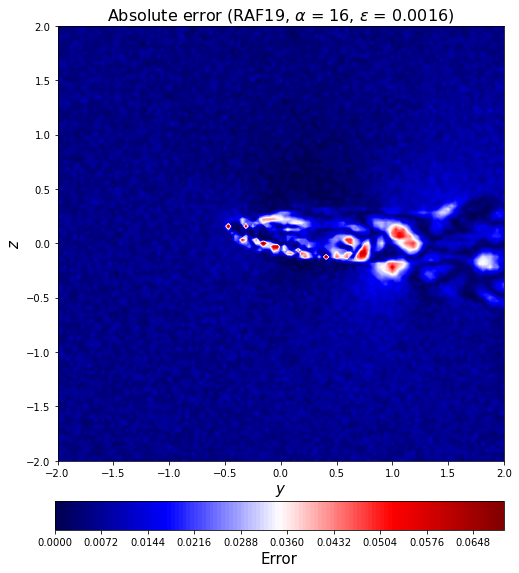

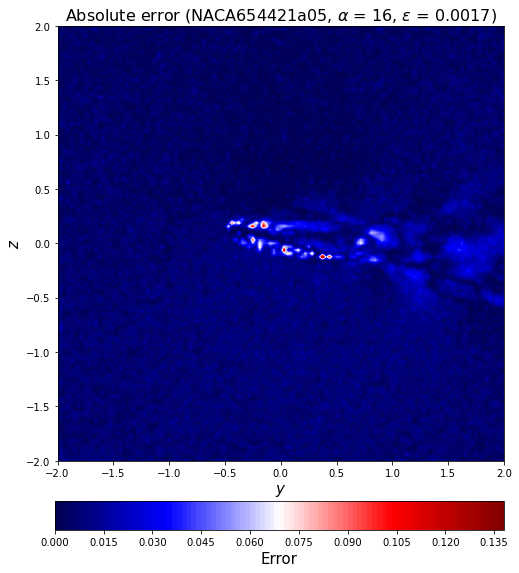

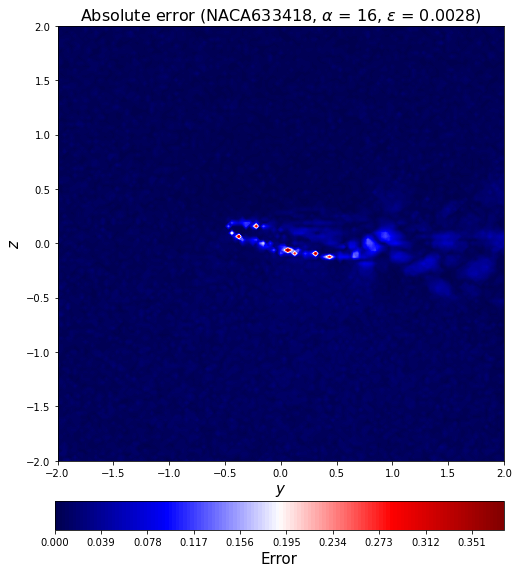

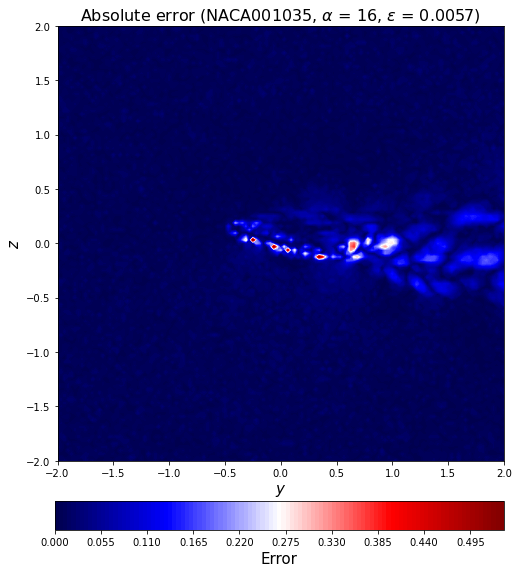

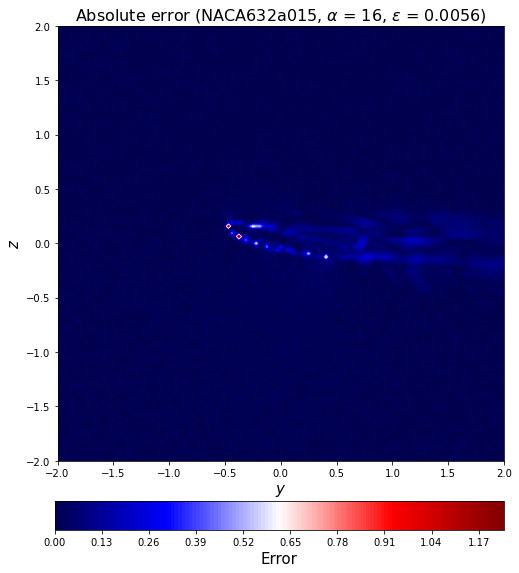

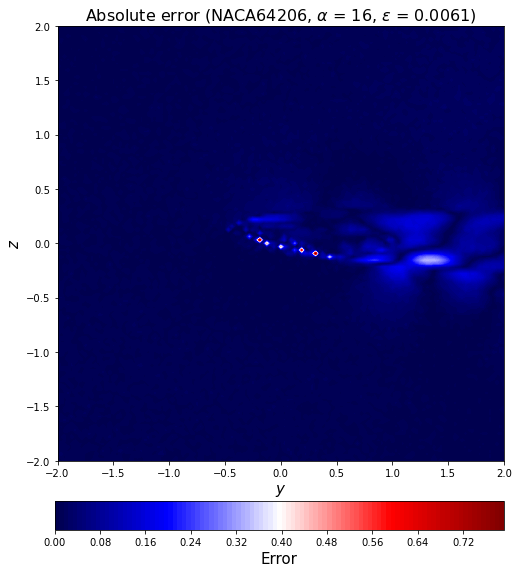

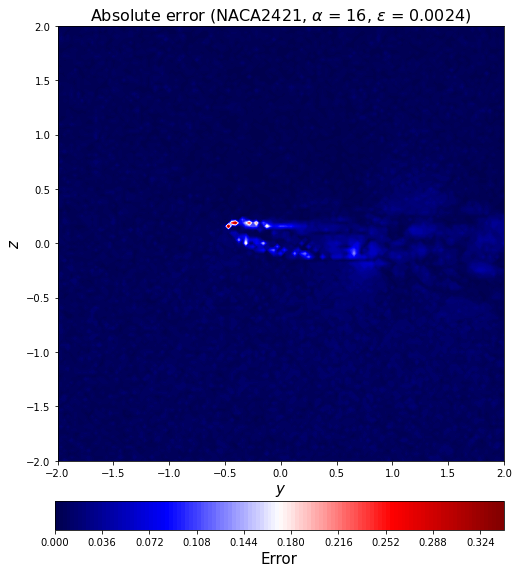

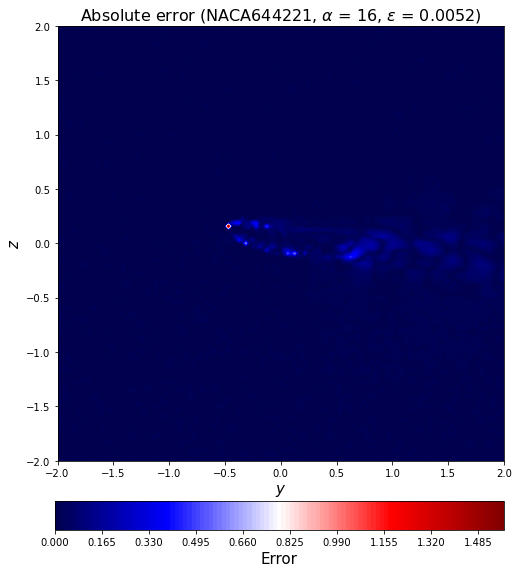

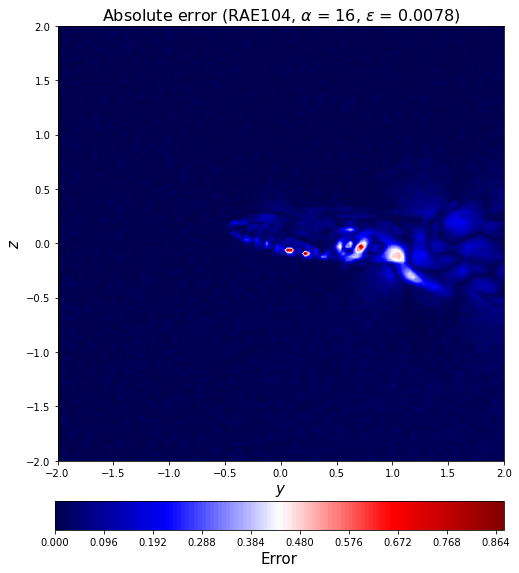

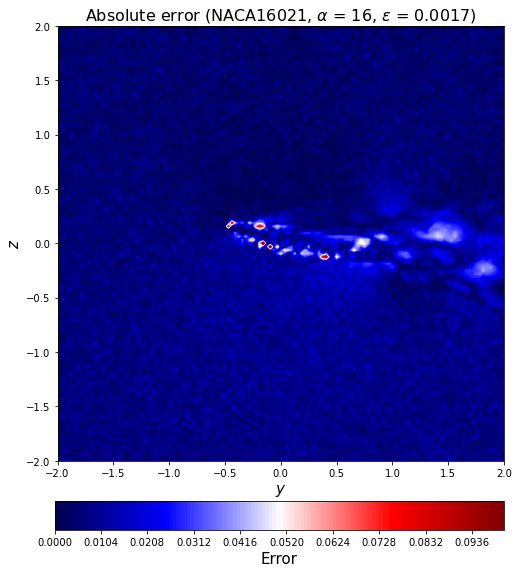

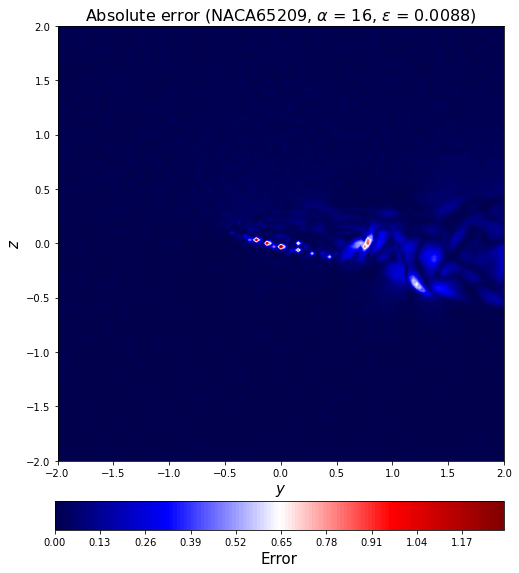

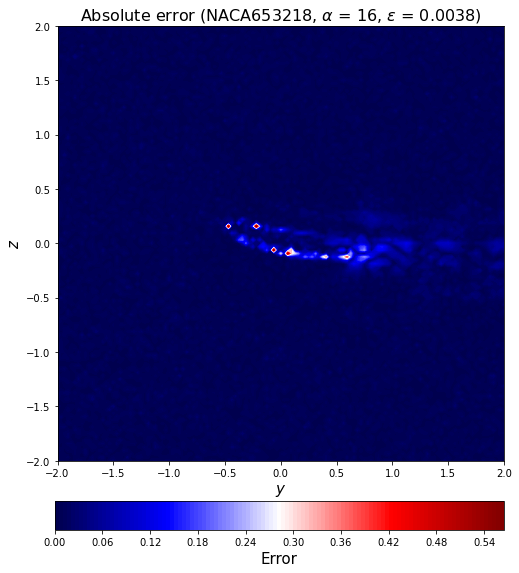

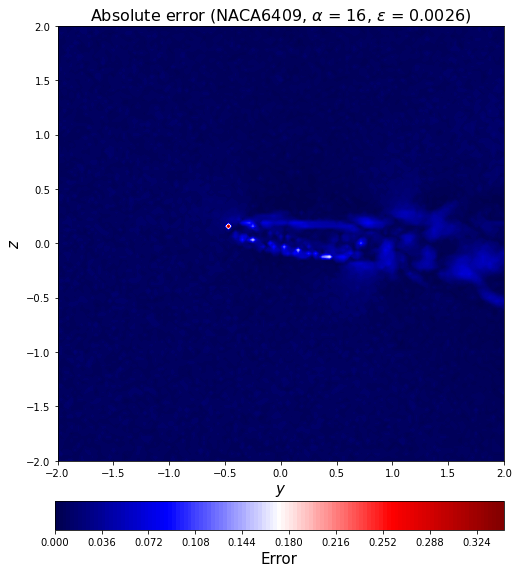

In [71]:
for c in range(0,20):
    error_train_abs2_rotate = error_train_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_train_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_train[c])[3:-2],
                                                                       aa_train[c], l2_error_train_list[c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    saveName = case_storage+ "\\trainingError"+str(np.array2string(geo_train[c])[3:-2])+"_alpha"+str(aa_train[c])+".jpg"
    plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

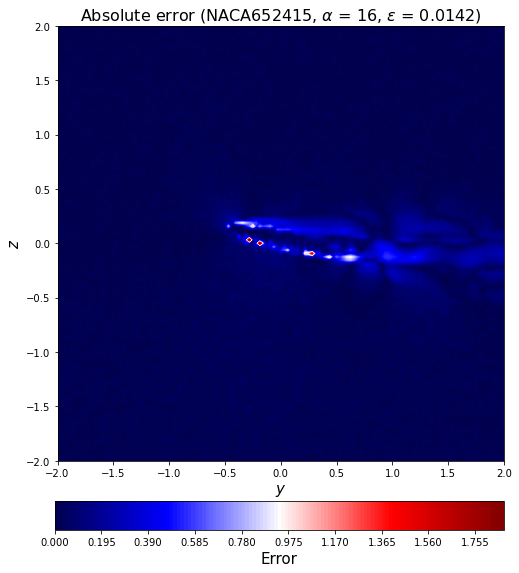

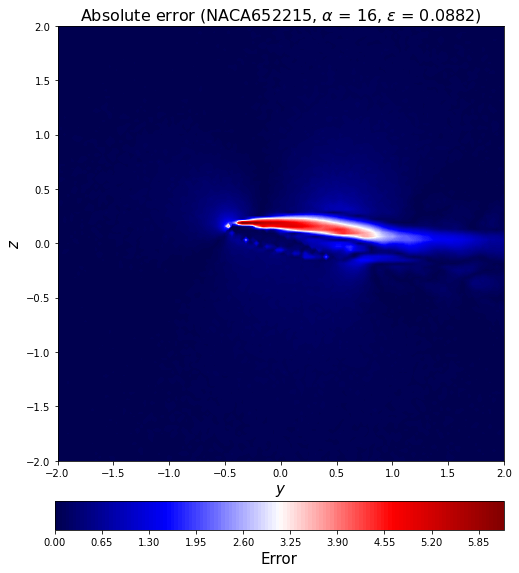

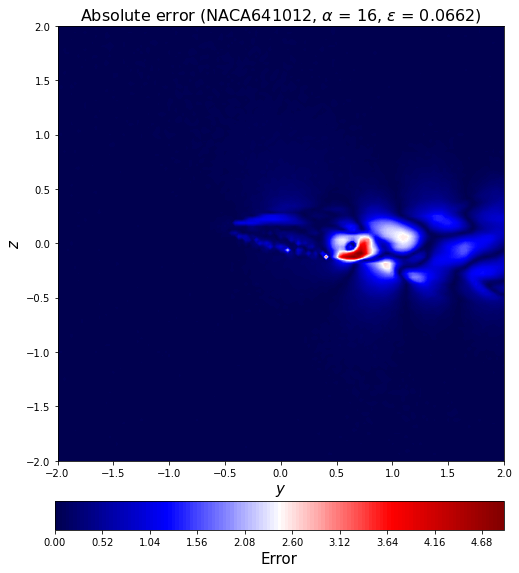

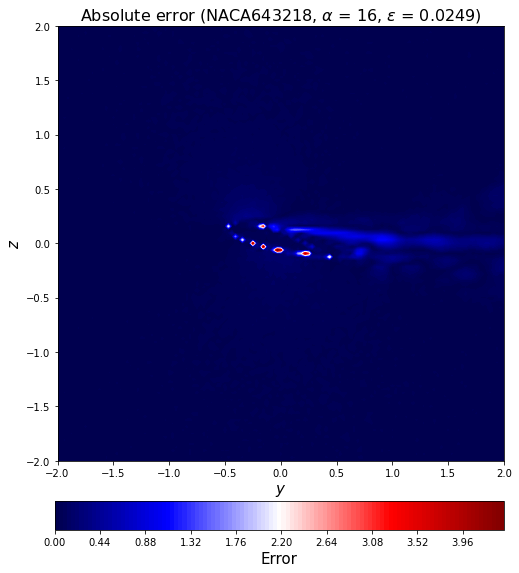

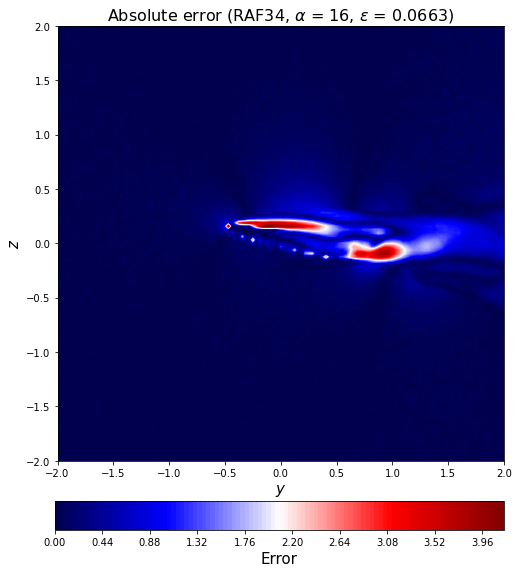

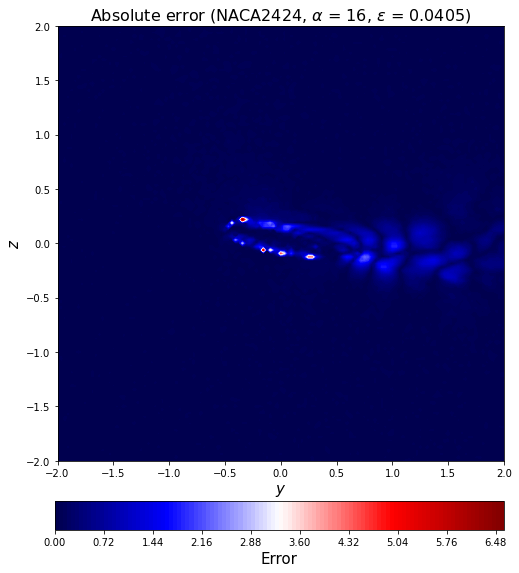

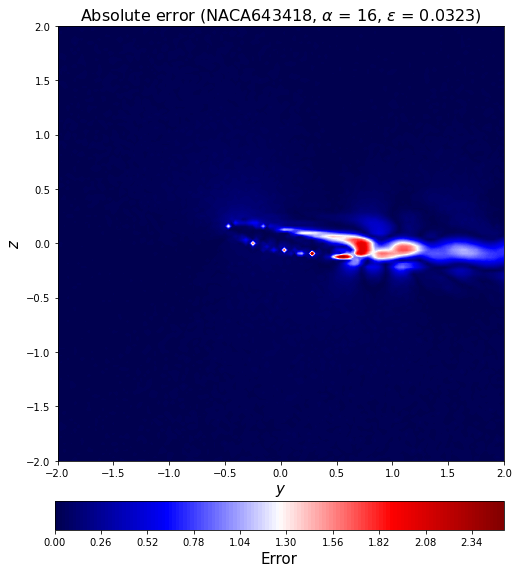

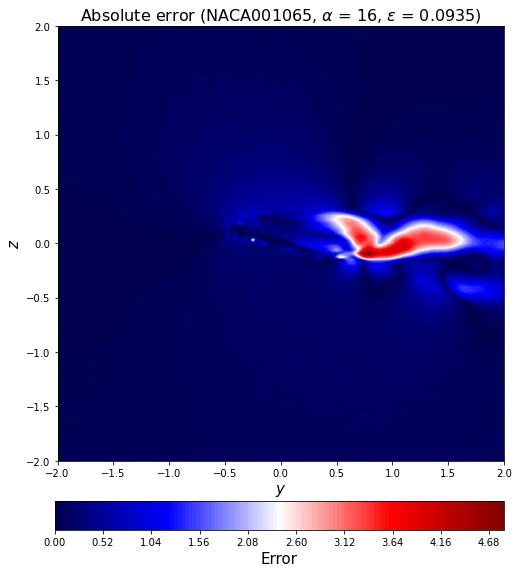

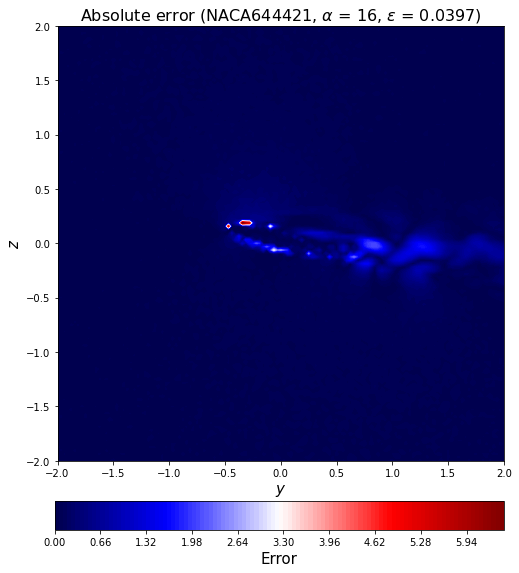

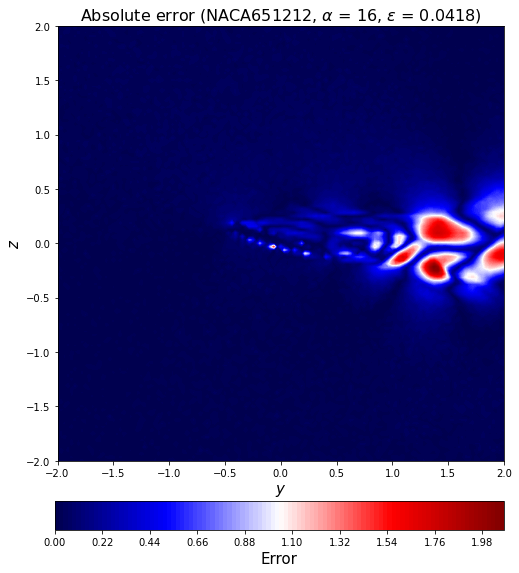

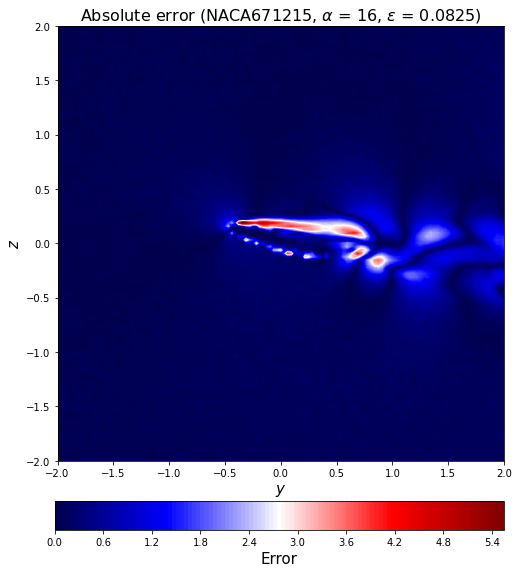

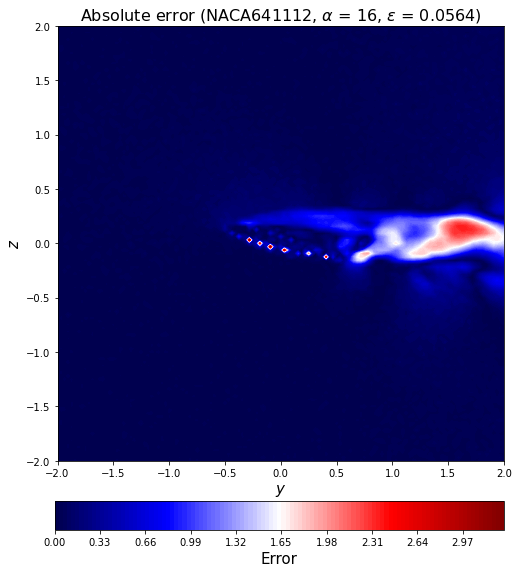

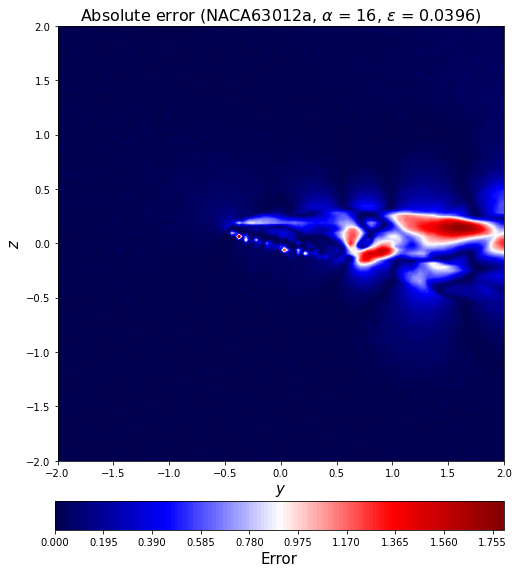

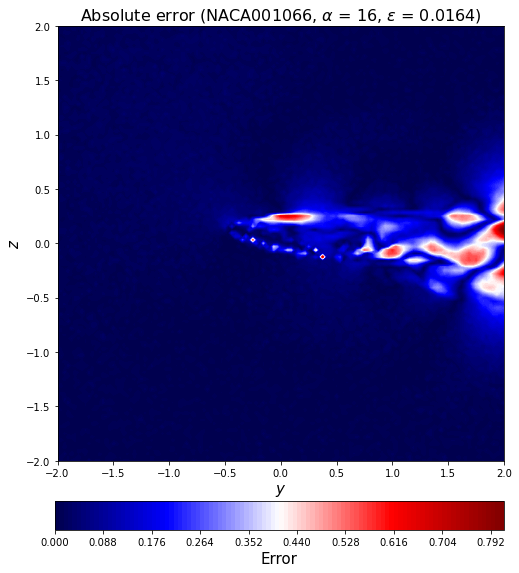

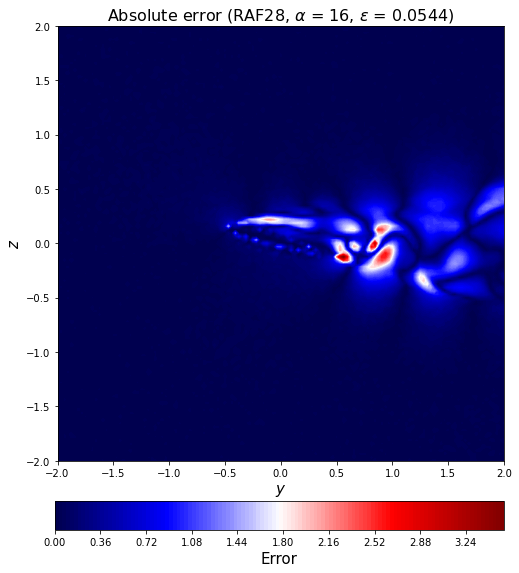

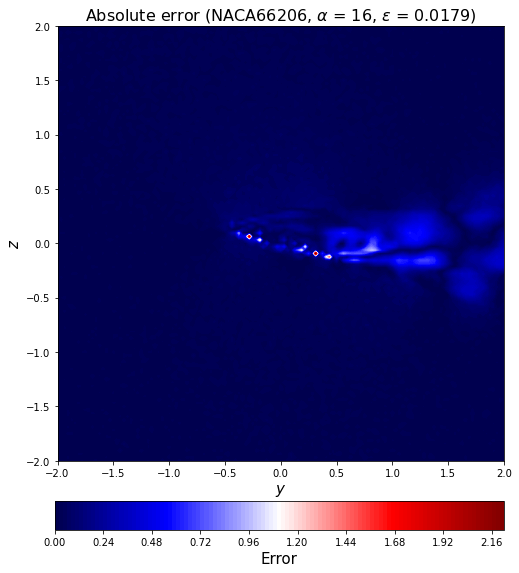

In [72]:
for c in range(0,16):
    error_val_abs2_rotate = error_val_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_val_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_val[c])[3:-2],
                                                                       aa_val[c], l2_error_val_list[c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    saveName = case_storage+ "\\validationError"+str(np.array2string(geo_val[c])[3:-2])+"_alpha"+str(aa_val[c])+".jpg"
    plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()